### Final EWMACD Method

In [48]:
# globals (dev)
FOLDER_MODULES = r'C:\Users\Lewis\Documents\GitHub\tenement-tools\modules'  
FOLDER_SHARED = r'C:\Users\Lewis\Documents\GitHub\tenement-tools\shared'
GRP_LYR_FILE = r"C:\Users\Lewis\Documents\GitHub\tenement-tools\arc\lyr\group_template.lyrx"

# set gdal global environ
import os
os.environ['GDAL_DISABLE_READDIR_ON_OPEN'] = 'EMPTY_DIR'
os.environ['CPL_VSIL_CURL_ALLOWED_EXTENSIONS '] = 'tif'
os.environ['VSI_CACHE '] = 'TRUE'
os.environ['GDAL_HTTP_MULTIRANGE '] = 'YES'
os.environ['GDAL_HTTP_MERGE_CONSECUTIVE_RANGES '] = 'YES'

# also set rasterio env variables
rasterio_env = {
    'GDAL_DISABLE_READDIR_ON_OPEN': 'EMPTY_DIR',
    'CPL_VSIL_CURL_ALLOWED_EXTENSIONS':'tif',
    'VSI_CACHE': True,
    'GDAL_HTTP_MULTIRANGE': 'YES',
    'GDAL_HTTP_MERGE_CONSECUTIVE_RANGES': 'YES'
}

# safe imports
import sys                      # arcgis comes with these
import shutil                   # arcgis comes with these
import datetime                 # arcgis comes with these
import numpy as np              # arcgis comes with these
import pandas as pd             # arcgis comes with these
import arcpy                    # arcgis comes with these
import tempfile                 # arcgis comes with these
import matplotlib.pyplot as plt
import smtplib
import mimetypes
from datetime import datetime   # arcgis comes with these
from email.message import EmailMessage
from email.utils import make_msgid



# risky imports (not native to arcgis)
try:
    import xarray as xr
    import dask
    import rasterio
    import pystac_client
    import osr
    import json
    from scipy.signal import savgol_filter
    from odc import stac
    from osgeo import gdal
    from osgeo import ogr
    from osgeo import osr
except:
    arcpy.AddError('Python libraries xarray, dask, rasterio, pystac, or odc not installed.')
    raise # return

# import tools
try:
    # shared folder
    sys.path.append(FOLDER_SHARED)
    import arc, satfetcher, tools

    # module folder
    sys.path.append(FOLDER_MODULES)
    import nrt, cog_odc, cog
except:
    arcpy.AddError('Could not find tenement tools python scripts (modules, shared).')
    raise
    
# disable future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=dask.array.core.PerformanceWarning)
    
# grab parameter values 
in_feat = r"C:\Users\Lewis\Desktop\nrt_projects\Opthalmia\monitoring_areas.gdb\monitoring_areas"
in_ongoing = False
in_time_interval = 24
#in_email_from = parameters[3].value                # email from 
#in_smtp_server = parameters[4].value               # email smtp server 
#in_smtp_port = parameters[5].value                 # email smtp port 
#in_smtp_username = parameters[6].value             # email smtp username 
#in_smtp_password = parameters[7].value             # email smtp password 


# # # # #
# notify user and set up progress bar
#arcpy.AddMessage('Beginning NRT Monitoring of areas.')
#arcpy.SetProgressor(type='step', 
                    #message='Preparing parameters...',
                    #min_range=0, max_range=20)
        
# set up initial continous monitoring var
continue_monitoring = True

# check if time interval is > 0
#in_time_interval = in_time_interval * 60 * 60
#if in_time_interval <= 0:
    #arcpy.AddError('Time interval must be above 0 hours.')
    #raise


# # # # #
# notify and increment progress bar
#arcpy.SetProgressorLabel('Preparing parameters...')
#arcpy.SetProgressorPosition(1)

# get path to monitoring areas feature
feat_desc = arcpy.Describe(in_feat)
in_feat = os.path.join(feat_desc.path, feat_desc.name)


# # # # #
# notify and increment progress bar
#arcpy.SetProgressorLabel('Validating monitoring areas...')
#arcpy.SetProgressorPosition(2)

# validate monitoring area feature class
if not nrt.validate_monitoring_areas(in_feat):
    arcpy.AddError('Monitoring areas feature is invalid.')
    raise # return

    
# # # # #
# notify and increment progress bar
#arcpy.SetProgressorLabel('Loading monitoring area json data...')
#arcpy.SetProgressorPosition(2)
    
# prepare path to expected json file
in_path = os.path.dirname(in_feat)
in_path = os.path.splitext(in_path)[0]
in_path = os.path.dirname(in_path)
#in_data_path = os.path.join(in_path, 'data.json')
    
    
# # # # #
# notify and increment progress bar
#arcpy.SetProgressorLabel('Loading monitoring area features...')
#arcpy.SetProgressorPosition(2)

# set required fields
fields = [
    'area_id', 
    'platform', 
    's_year', 
    'e_year', 
    'index', 
    'persistence', 
    'rule_1_min_conseqs', 
    'rule_1_inc_plateaus', 
    'rule_2_min_zone', 
    'rule_3_num_zones', 
    'ruleset', 
    'alert', 
    'method',
    'alert_direction', 
    'email', 
    'ignore', 
    'color', 
    'global_id', 
    'SHAPE@'
]

# get feature count and data
try:
    #feats = arcpy.da.SearchCursor(in_feat, fields)
    feats = []
    with arcpy.da.SearchCursor(in_feat, fields) as cursor:
        for row in cursor:
            feats.append(row)
except:
    arcpy.AddError('Could not open monitoring areas feature.')
    raise # return

In [49]:
from importlib import reload
reload(nrt)

<module 'nrt' from 'C:\\Users\\Lewis\\Documents\\GitHub\\tenement-tools\\modules\\nrt.py'>

In [3]:
# todo:
# remove field rule 1 inc plateaus ... ?
# remove field rule 2 bidirection. we do this via alert dir now - DONE
# change rule 2 min stdv to min zone - DONE
# consider a 'negative remover in positive areas' and vice versa. consider during alert?... add as extra alert dirs? - DONE
# append all mon area field info to netcdf attr, check at start of run for change, delete cube if change
# check if ruleset contains rule without a value entered during area creation (fields accepts nulls) - FORCED REQUIRED!

In [4]:
# 'inc_any':      'Incline only (any)', 
# 'dec_any':      'Decline only (any)', 
# 'inc_pos':      'Incline only (+ zones only)', 
# 'dec_neg':      'Decline only (- zones only)', 
# 'both_any':     'Incline or Decline (any)',
# 'both_pos_neg': 'Incline or Decline (+/- zones only)',

In [5]:
# tips
# use higher persistence for dynamic (1) and lower for static (0.5)
# use decline in - or pos in + only for dynamic to avoid new regime shifts triggering alarm
# turn off spikes for dynamic

In [42]:
# TESTING REMOVE THIS WHEN DONE!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
class MonitoringArea:
    """
    """

    # TESTING_END_DT REMOVE THIS WHEN DONE!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    def __init__(self, feat, path):
        
        # feature fields
        self.area_id = feat[0]
        self.platform = feat[1]
        self.s_year = feat[2]
        self.e_year = feat[3]
        self.index = feat[4]
        self.persistence = feat[5]
        self.rule_1_min_conseqs = feat[6]
        self.rule_1_inc_plateaus = feat[7]
        self.rule_2_min_zone = feat[8]
        self.rule_3_num_zones = feat[9]
        self.ruleset = feat[10]
        self.alert = feat[11]
        self.method = feat[12]
        self.alert_direction = feat[13]
        self.email = feat[14]
        self.ignore = feat[15]
        self.color = feat[16]
        self.global_id = feat[17]
        
        # feature geometry
        self.raw_geom = feat[18]
        self.prj_geom = None
        
        # path to project folder
        self.path = path
        
        # xr datasets
        self.ds_old = None
        self.ds_new = None
        self.ds_cmb = None
        self.ds_anl = None
        
        # current alert info
        self.alert_date = None
        self.alert_zone = None
        self.alert_flag = None
        
        # html and graph info
        self.alert_html = None
        self.alert_graph = None
        
        # TESTING REMOVE THIS WHEN DONE!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        self.TESTING_END_DT = None
        

    def show_area_info(self):
        """
        Simple function to print field information to 
        screen.
        """
        
        # print field attributes
        for field in list(vars(self))[:16]:
            print('{}: {}'.format(field, vars(self).get(field)))
            
        return

    
    def show_alert_info(self):
        """
        Simple function to print alert information to 
        screen.
        """
        
        # print field attributes
        for field in list(vars(self))[25:31]:
            print('{}: {}'.format(field, vars(self).get(field)))
            
        return    
    
    
    def validate_area(self):
        """
        Checks all required monitoring area parameters are 
        valid. Raises an error if invalid.
        """
        
        # check area id
        if self.area_id is None:
            raise ValueError('No area id exists.')

        # check platform
        if self.platform not in ['Landsat', 'Sentinel']:
            raise ValueError('Platform not Landsat or Sentinel.')

        # check start, end years
        if not isinstance(self.s_year, int):
            raise ValueError('Start year not an integer.')
        elif not isinstance(self.e_year, int):
            raise ValueError('End year not an integer.')
        elif self.s_year < 1980 or self.s_year > 2050:
            raise ValueError('Start year not between 1980-2050.')        
        elif self.e_year < 1980 or self.e_year > 2050:
            raise ValueError('End year not between 1980-2050.')          
        elif self.e_year <= self.s_year:
            raise ValueError('End year is <= start year.')           
        elif abs(self.e_year - self.s_year) < 2:
            raise ValueError('Training period < 2 years in length.')  
        elif self.platform == 'Sentinel' and self.s_year < 2016:
            raise ValueError('Start year must be >= 2016 for Sentinel data.')  

        # check index
        if self.index not in ['NDVI', 'MAVI', 'kNDVI']:
            raise ValueError('Index must be NDVI, MAVI or kNDVI.')

        # check persistence
        if self.persistence is None:
            raise ValueError('No persistence exists.')
        elif self.persistence < 0.001 or self.persistence > 9.999:
            raise ValueError('Persistence not between 0.0001 and 9.999.')

        # check rule 1 min consequtives
        if self.rule_1_min_conseqs is None:
            raise ValueError('No rule 1 min conseqs exists.')
        elif self.rule_1_min_conseqs < 0 or self.rule_1_min_conseqs > 999:
            raise ValueError('Rule 1 min conseqs not between 0 and 999.')

        # check rule 1 inc plateaus
        if self.rule_1_inc_plateaus is None:
            raise ValueError('No rule 1 inc plateaus exists.')
        elif self.rule_1_inc_plateaus not in ['Yes', 'No']:
            raise ValueError('Rule 1 inc plateaus must be Yes or No.')

        # check rule 2 min zone
        if self.rule_2_min_zone is None:
            raise ValueError('No rule 2 min zone exists.')
        elif self.rule_2_min_zone < 1 or self.rule_2_min_zone > 11:
            raise ValueError('Rule 2 min zone not between 1 and 11.') 
            
        # check rule 3 num zones
        if self.rule_3_num_zones is None:
            raise ValueError('No rule 3 num zones exists.')
        elif self.rule_3_num_zones < 1 or self.rule_3_num_zones > 11:
            raise ValueError('rule 3 num zones not between 1 and 11.')             

        # set up allowed rulesets
        rulesets = [
            '1 only',
            '2 only',
            '3 only',
            '1 and 2',
            '1 and 3',
            '2 and 3',
            '1 or 2',
            '1 or 3',
            '2 or 3',
            '1 and 2 and 3',
            '1 or 2 and 3',
            '1 and 2 or 3',
            '1 or 2 or 3'
        ]
        
        # check ruleset   
        if self.ruleset not in rulesets:
            raise ValueError('Rulset not supported.')

        # check alert
        if self.alert not in ['Yes', 'No']:
            raise ValueError('Alert must be Yes or No.')

        # check method
        if self.method not in ['Static', 'Dynamic']:
            raise ValueError('Method must be Static or Dynamic')

        # set up alert directions 
        alert_directions = [
            'Incline only (any)', 
            'Decline only (any)', 
            'Incline only (+ zones only)', 
            'Decline only (- zones only)', 
            'Incline or Decline (any)',
            'Incline or Decline (+/- zones only)'
        ]

        # check alert direction
        if self.alert_direction not in alert_directions:
            raise ValueError('Alert direction is not supported.')

        # check email address
        if self.alert == 'Yes' and self.email is None:
            raise ValueError('No email provided.')
        elif self.email is not None and '@' not in self.email:
            raise ValueError('Email address invalid.')

        # check ignore
        if self.ignore not in ['Yes', 'No']:
            raise ValueError('Ignore must be Yes or No.')
            
        # check global id
        if self.global_id is None:
            raise ValueError('No global id exists.')
            
        # check path provided
        if self.path is None:
            raise ValueError('No project path exists.')

        return
        
        
    def set_old_xr(self):
        """
        If a path exists for old xr, load and set it. 
        If old xr does not exist (i.e., first time area
        has been monitored, set None. If error during load, 
        set old xr to None.
        """
        
        try:
            # build expected netcdf filepath
            nc_path = os.path.join(self.path, self.global_id + '.nc')
        
            # check input path and store if so, else none
            if os.path.exists(nc_path):
                with xr.open_dataset(nc_path) as ds:
                    ds.load()
                
                # set old ds
                self.ds_old = ds
                return
            
            else:
                # set to none
                self.ds_old = None
                return
        
        except:
            self.ds_old = None
            return
        
        return
            
    
    def validate_old_xr(self):
        """
        If old xr is loaded and set, validates it to ensure 
        it has attributes that match current area feature. 
        Done to ensure user has not changed area field values
        since last run. If old xr attributes and current area 
        do not match, set old xr dataset to None (i.e., reset
        it).
        """
        
        # if old xr doesnt exist, leave
        if self.ds_old is None:
            return
            
        # check xr is valid
        if not isinstance(self.ds_old, xr.Dataset):
            self.ds_old = None
            return
        elif not hasattr(self.ds_old, 'attrs'):
            self.ds_old = None
            return

        try:
            # check key attrs in dataset
            attrs = list(vars(self))[:16]
            for attr in attrs:
                if not hasattr(self.ds_old, attr):
                    self.ds_old = None
                    return

            # check all vals match match (remove tail, add method back on)
            attrs = attrs[:11] + ['method']
            for attr in attrs:
                new = str(vars(self).get(attr))
                old = str(self.ds_old.attrs.get(attr))

                if new != old:
                    self.ds_old = None
                    return
                    
        except:
            self.ds_old = None
            return
        
        return
            
    
    # TODO SET END DATE TO 2050 WHEN DONE
    def set_new_xr(self):
        """
        Fetches all available digital earth australia (dea) 
        landsat/sentinel data for area bounding box. The 
        resulting data is set to the new xr. If old xr 
        exists (is not None), new xr is then subset down to 
        only the dates that dont exist in old xr. 
        
        If an error occurs, an error is raised. 
        """
        
        # set endpoint
        STAC_ENDPOINT = 'https://explorer.sandbox.dea.ga.gov.au/stac'
        
        # check platform is valid
        if self.platform not in ['Landsat', 'Sentinel']:
            raise ValueError('Platform not supported.')

        # prepare dea stac search parameters
        if self.platform == 'Landsat':
            
            # set dea collection names
            collections = [
                'ga_ls5t_ard_3',
                'ga_ls7e_ard_3',
                'ga_ls8c_ard_3',
                'ga_ls8c_ard_provisional_3'
            ]
            
            # set bands
            bands = [
                'nbart_red', 
                'nbart_green', 
                'nbart_blue', 
                'nbart_nir', 
                'nbart_swir_1', 
                'nbart_swir_2', 
                'oa_fmask'
            ]
            
        elif self.platform == 'Sentinel':
            
            # set dea collection names
            collections = [
                's2a_ard_granule',  # todo: use ver 3 when avail
                's2b_ard_granule',  # todo: use ver 3 when avail
                'ga_s2am_ard_provisional_3',
                'ga_s2bm_ard_provisional_3'
            ]
            
            # set bands
            bands = [
                'nbart_red', 
                'nbart_green', 
                'nbart_blue', 
                'nbart_nir_1', 
                'nbart_swir_2', 
                'nbart_swir_3', 
                'fmask'
            ]
        
        
        try:
            # ensure raw geom is in wgs84 (set prj_geom)
            srs = arcpy.SpatialReference(4326)
            self.prj_geom = self.raw_geom.projectAs(srs)
            
            # convert to bounding box in wgs84
            prj_bbox = [
                self.prj_geom.extent.XMin,
                self.prj_geom.extent.YMin,
                self.prj_geom.extent.XMax,
                self.prj_geom.extent.YMax
            ]
        
        except Exception as e:
            raise ValueError(e)
            
            
        try:
            # get all avail dea satellite data without compute
            self.ds_new = nrt.fetch_cube_data(collections=collections, 
                                              bands=bands, 
                                              start_dt='1980-01-01', 
                                              end_dt=self.TESTING_END_DT,     #'2050-12-31', 
                                              bbox=prj_bbox, 
                                              resolution=10, 
                                              ds_existing=None)
        
            # group duplicate times if exist
            self.ds_new = satfetcher.group_by_solar_day(self.ds_new)
            
        except Exception as e:
            raise ValueError(e)
            
            
        try:
            # subset new xr to new dates (if old exists)
            if self.ds_old is not None:
                
                # get last datetime in old dataset
                last_dt = self.ds_old['time'].isel(time=-1)
                
                # get all datetimes in new dataset
                new_dts = self.ds_new['time']
                new_dts = new_dts.where(new_dts['time'] > last_dt, drop=True)
                
                # select only new
                self.ds_new = self.ds_new.sel(time=new_dts)       
                
            # enforce none type if no new dates
            if len(self.ds_new['time']) == 0:
                self.ds_new = None
                
        except Exception as e:
            raise ValueError(e)
            
        return
    
    
    def new_xr_dates_found(self):
        """
        Does quick check to see if any new xr dates currently 
        exist. Returns true if times exist, false if not.
        """
        
        # check if dates exist
        if self.ds_new is None:
            return False
        elif 'time' not in self.ds_new:
            return False
        elif len(self.ds_new['time']) == 0:
            return False
        else:
            return True
        
        return
        
        
    def count_new_xr_dates(self):
        """
        Get number of dates in new xr.
        """
        
        # count based on time dim
        if self.ds_new is not None:
            return len(self.ds_new['time'])
        
        return
    
    
    def apply_new_xr_fmask(self):
        """
        Takes the new xr and applies the dea fmask band to 
        remove invalid pixels and dates. If an error occurs,
        error is raised.
        """
        
        # check if new xr exists
        if self.ds_new is None:
            raise ValueError('No new xr provided.')
        
        try:
            # get mask band name (either be oa_fmask or fmask)
            mask = [v for v in self.ds_new if 'mask' in v][0]
            
            # mask invalid pixels i.e., not valid, water, snow
            self.ds_new = cog.remove_fmask_dates(ds=self.ds_new, 
                                                 valid_class=[1, 4, 5],
                                                 max_invalid=0,
                                                 mask_band=mask, 
                                                 nodata_value=np.nan,
                                                 drop_fmask=True)
        except Exception as e:
            raise ValueError(e)
            
        return
    
    
    def apply_new_xr_index(self):
        """
        Takes the new xr and applies user chosen vegetation
        index. If an error occurs, error is raised. 
        """
        
        # check if new xr exists
        if self.ds_new is None:
            raise ValueError('No new xr provided.')
        
        # check if platform set
        if self.platform not in ['Landsat', 'Sentinel']:
            raise ValueError('Platform not supported.')
            
        # check if index set
        if self.index not in ['NDVI', 'MAVI', 'kNDVI']:
            raise ValueError('Index not supported.')
        
        try:
            # conform dea band names and calc vegetation index
            platform = self.platform.lower()
            self.ds_new = satfetcher.conform_dea_ard_band_names(ds=self.ds_new, 
                                                                platform=platform) 
            
            # calculate vegetation index
            index = self.index.lower()
            self.ds_new = tools.calculate_indices(ds=self.ds_new, 
                                                  index=index, 
                                                  custom_name='veg_idx', 
                                                  rescale=False, 
                                                  drop=True)
        except Exception as e:
            raise ValueError(e)
            
        return
            
            
    def load_new_xr(self):
        """
        Loads new xr values into memory using the xarray 
        load function. This will result in downloading from 
        dea and can take awhile.
        """
        
        # check if new xr exists
        if self.ds_new is None:
            raise ValueError('No new xr provided.')
        
        try:
            # load new xr and close connection 
            self.ds_new.load()
            self.ds_new.close()
        
        except Exception as e:
            raise ValueError(e)
            
        return
    
    
    def remove_new_xr_edges(self):
        """
        Sets any pixels in the new xr to nodata (nan) if they occur 
        within the original bounding box but outside of the vector
        boundary of the monitoring area. This is achieved by creating 
        an in-memory raster of 1s and 0s (in boundary, out boundary) 
        and applies it to the new dataset. If an error occurs,
        no mask is applied.
        """ 
        
        # check if new xr exists
        if self.ds_new is None:
            raise ValueError('No new xr provided.')
            
        # check if raw geometry exists
        if self.raw_geom is None:
            raise ValueError('No raw area geometry provided.')       
        
        try:
            # take a copy in case of error
            tmp = self.ds_new.copy(deep=True)
            
            # rasterize area polygon, set outside pixels to nan
            mask = nrt.rasterize_polygon(ds=self.ds_new, 
                                         geom=self.raw_geom)
            
            # mask edge pixels to nan
            self.ds_new = self.ds_new.where(mask)
            
            # check if not all nan
            if self.ds_new.to_array().isnull().all():
                raise ValueError('Mask set all pixels to nan, rolling back.')  

        except Exception as e:
            self.ds_new = tmp
            raise ValueError(e)
            
        return
            

    def reduce_new_xr(self):
        """
        Reduces new xr dataset into temporal medians. That is, one 
        median vegetation index value for the entire monitoring area 
        per date. If an error occurs, error is raised.
        """
        
        # check if new xr exists
        if self.ds_new is None:
            raise ValueError('No new xr provided.')        
        
        try:
            # get temporal medians
            self.ds_new = self.ds_new.median(['x', 'y'])
        
        except Exception as e:
            raise ValueError(e)
            
        return
    
    
    def interp_new_xr_nans(self):
        """
        Interpolates any existing nan values in new xr linearly.
        If nan values still exist after interpolation (often on
        edge dates due to lack of extrapolation), these will be
        dropped. If error occurs or all values are nan, error is
        raised.
        """
        
        # check if new xr exists
        if self.ds_new is None:
            raise ValueError('No new xr provided.')          

        try:
            # interpolate na linearly
            self.ds_new = self.ds_new.interpolate_na('time')
            
            # check if any nan
            if self.ds_new.to_array().isnull().any():
                self.ds_new = self.ds_new.where(~self.ds_new.isnull(), 
                                                drop=True)
        except Exception as e:
            raise ValueError(e)
            
        # check we have data remaining
        if len(self.ds_new['time']) == 0:
            raise ValueError('No data remaining after nodata dropped.')
            
        return


    def append_new_xr_vars(self):
        """
        Appends required xr variables to new xr if do not exist.
        These variables are required for storing outputs from 
        change detection results, cleaned vegetation, etc. If
        error, error is raised.
        """
        
        # check if new xr exists
        if self.ds_new is None:
            raise ValueError('No new xr provided.')  
        
        # set required variable names
        new_vars = [
            'veg_clean', 
            'static_raw', 
            'static_clean',
            'static_rule_one',
            'static_rule_two',
            'static_rule_three',
            'static_zones',
            'static_alerts',
            'dynamic_raw', 
            'dynamic_clean',
            'dynamic_rule_one',
            'dynamic_rule_two',
            'dynamic_rule_three',
            'dynamic_zones',
            'dynamic_alerts'
        ]        
        
        # iter var names and append to xr
        for var in new_vars:
            if var not in self.ds_new:
                da = xr.full_like(self.ds_new['veg_idx'], np.nan)
                self.ds_new[var] = da
        
        return
        
            
    def set_cmb_xr(self):
        """
        Takes old xr (if exists) and concatenates the new 
        xr dates and values onto the end of the old xr (if
        exists). A single cmb (combined) xr is created as
        a result. This is done to ensure old xr change and
        vegetation values persist from one monitoring
        cycle to another. If no old xr exists, new xr is
        set to as cmb xr. If error, error raised.
        """
        
        # check if new xr exists
        if self.ds_new is None:
            raise ValueError('No new xr provided.')
            
        # set new xr to cmb xr if no old xr
        if self.ds_old is None:
            self.ds_cmb = self.ds_new.copy(deep=True)
            return
        
        try:
            # add new times onto end of old times
            xrs = [self.ds_old, self.ds_new]
            self.ds_cmb = xr.concat(xrs, dim='time')
            
            # sort by time
            self.ds_cmb = self.ds_cmb.sortby('time')
        
        except Exception as e:
            raise ValueError(e)
            
        return

    
    def fix_cmb_xr_spikes(self):
        """
        Detects severe vegetation index outliers using the TIMESAT 
        3.3 median spike detection method. Sets spike values to 
        nan and then interpolates them, if they exist. If error, error raised.
        """
        
        # check if cmb xr exists
        if self.ds_cmb is None:
            raise ValueError('No cmb xr provided.')
        
        try:
            # remove outliers via median spike method
            da = nrt.remove_spikes(da=self.ds_cmb['veg_idx'], 
                                   factor=1, 
                                   win_size=3)
            
            # interpolate nans linearly
            da = da.interpolate_na('time')
            
            # set result to clean var
            self.ds_cmb['veg_clean'] = da            
            
            # if nans still exists, drop them in cmb xr
            if da.isnull().any():
                self.ds_cmb = self.ds_cmb.where(~da.isnull(), drop=True)
        
        except Exception as e:
            raise ValueError(e)
            
        # check we still have data remaining
        if len(self.ds_cmb['time']) == 0:
            raise ValueError('No data remaining after no data dropped.')
            
        return

    
    # if got time, see if can improve nan mask approach. id rather a vectorized approach
    def smooth_cmb_xr_index(self):
        """
        Mildly smoothes the cmb xr clean vegetation index values 
        using the savitsky golay filter. If error, error raised.
        """

        # check if cmb xr exists
        if self.ds_cmb is None:
            raise ValueError('No cmb xr provided.')
        
        # reduce code with a array
        da = self.ds_cmb['veg_clean']
        
        # mask if needed
        mask = None
        if da.isnull().any():
            mask = da.isnull()
            da = da.where(~mask, da.mean())
        
        try:
            # get time dimension axis
            dims = list(da)
            for idx, dim in enumerate(dims):
                if dim == 'time':
                    axis = idx

            # set up kwargs
            kwargs={
                'window_length': 3, 
                'polyorder': 1,
                'axis': axis
            }

            # apply savitsky filter to outlier-free index
            da = xr.apply_ufunc(savgol_filter, 
                                da,
                                dask='allowed',
                                kwargs=kwargs)
                
            # reset nan values if found
            if mask is not None:
                da = da.where(~mask, np.nan)
            
            # update existing values in cmb xr
            self.ds_cmb['veg_clean'] = da
        
        except Exception as e:
            raise ValueError(e)
            
        return
    

    def set_anl_xr(self):
        """
        Takes cmb xr (if exists) and copys it in memory. The
        copied xr dataset is then subset to the training start 
        year (all years before are removed). The result is the anl 
        (analysis) xr, which is exists to be used temporarily to 
        generate new change models. If error, error raised.
        """
        
        # check if start year is valid
        if self.s_year is None:
            raise ValueError('Not training start year provided.')

        # check if cmb xr exists
        if self.ds_cmb is None:
            raise ValueError('No cmb xr provided.')
            
        try:
            # copy cmb xr to anl xr
            self.ds_anl = self.ds_cmb.copy(deep=True)
            
            # remove all dates before start year
            dts = self.ds_anl['time.year'] >= self.s_year
            self.ds_anl = self.ds_anl.where(dts, drop=True)
                    
        except Exception as e:
            raise ValueError(e)
            
        # check if dates valid
        if len(self.ds_anl) == 0:
            raise ValueError('No dates remaning in dataset.')
        elif len(area.ds_cmb.groupby('time.year')) < 3:
            raise ValueError('Not enough years remaining in dataset.')
        
        return
        

    # TODO play with smoothing, persistence - 
    # ALSO TRY MIN TRAINING LENGTH COULD WORK!!! set to 1 year worth of dates, 2 years worth of dates, etc
    # ALSO check if dims in correct order for static and dynamic raw outputs
    # area_summary.ds['static_raw'] = area_summary.ds['static_raw'].transpose('time', 'y', 'x')
    def detect_change_anl_xr(self):
        """
        Performs ewmacd change detection (static and dynamic 
        types) on anl xr. Uses the raw vegetation index time
        series to detect the change. If error or all nan, error 
        raised.
        """

        # check if anl xr exists
        if self.ds_anl is None:
            raise ValueError('No anl xr provided.')
            
        # check start and end years valid
        if self.s_year is None or self.e_year is None:
            raise ValueError('No start and/or end year provided.')        
            
        # check if persistence is valid
        if self.persistence is None:
            raise ValueError('No persistence provided.')
            
        try:
            # perform ewmacd change detection
            self.ds_anl = nrt.detect_change(ds=self.ds_anl,
                                            method='both',
                                            var='veg_idx',
                                            train_start=self.s_year,
                                            train_end=self.e_year,
                                            persistence=self.persistence)
        except Exception as e:
            raise ValueError(e)
            
        # check if we have data
        for var in ['static_raw', 'dynamic_raw']:
            if self.ds_anl[var].isnull().all():
                raise ValueError('Change result is empty.')            
            
        return
    
    
    # if got time, see if can improve nan mask approach. id rather a vectorized approach
    def smooth_anl_xr_change(self):
        """
        Mildly smoothes the anl xr static and dynamic change 
        signal values using the savitsky golay filter. If error, 
        error raised.
        """

        # check if anl xr exists
        if self.ds_anl is None:
            raise ValueError('No anl xr provided.')
            
        # set up static and dynamic arrays
        da_static = self.ds_anl['static_raw']
        da_dynamic = self.ds_anl['dynamic_raw']

        # create static mask if needed
        mask_static = None
        if da_static.isnull().any():
            mask_static = da_static.isnull()
            da_static = da_static.where(~mask_static, da_static.mean())
        
        # now create dynamic mask if needed
        mask_dynamic = None
        if da_dynamic.isnull().any():
            mask_dynamic = da_dynamic.isnull()
            da_dynamic = da_dynamic.where(~mask_dynamic, da_dynamic.mean())

        try:
            # get time dimension axis
            dims = list(self.ds_anl.dims)
            for idx, dim in enumerate(dims):
                if dim == 'time':
                    axis = idx

            # set up kwargs
            kwargs={
                'window_length': 3, 
                'polyorder': 1,
                'axis': axis
            }

            # apply savitsky filter to static change values
            da_static = xr.apply_ufunc(savgol_filter, 
                                       da_static,
                                       dask='allowed',
                                       kwargs=kwargs)

            # apply savitsky filter to dynamic change values
            da_dynamic = xr.apply_ufunc(savgol_filter, 
                                        da_dynamic,
                                        dask='allowed',
                                        kwargs=kwargs)
                
                        
            # reset static nan values if found
            if mask_static is not None:
                da_static = da_static.where(~mask_static, np.nan)
                
            # now reset dynamic nan values if found
            if mask_dynamic is not None:
                da_dynamic = da_dynamic.where(~mask_dynamic, np.nan)
            
            # update static, dynamic clean values in anl xr
            self.ds_anl['static_clean'] = da_static
            self.ds_anl['dynamic_clean'] = da_dynamic
            
        except Exception as e:
            raise ValueError(e)

        return      

    
    def transfer_old_to_anl_xr(self):
        """
        Takes old xr and transfers all historical values
        (i.e., everything except new values) to the anl xr
        (which contains everything from training period 
        onwards.) This is done to ensure fluctuations in 
        prior change values persists up until the newest 
        values. If an error occurs, error raised.
        """
        
        # if no old xr, skip transfer
        if self.ds_old is None:
            return
        
        # check if old and anl xr exists
        if self.ds_anl is None:
            raise ValueError('No anl xr provided.')
            
        # set up relevant vars
        data_vars = [
            'static_raw', 
            'static_clean', 
            'dynamic_raw', 
            'dynamic_clean'
        ]
        
        # ensure vars exist in both xrs
        for var in data_vars:
            if var not in self.ds_old or var not in self.ds_anl:
                raise ValueError('Missing variables in old and/or new xrs.')
        
        try:         
            # transfer vals from old to anl xr at matching dates
            self.ds_anl = nrt.transfer_xr_values(ds_to=self.ds_anl,
                                                 ds_from=self.ds_old,
                                                 data_vars=data_vars)
        except Exception as e:
            raise ValueError(e)
            
        return

            
    def build_zones(self):
        """
        Takes cleaned static and dynamic change deviation
        values and classifies them into 1 of 11 zones based
        on where the change value falls. Honours direction 
        of change by returning zone value with sign (+/-).
        If error occurs, error raised.
        """
        
        # check if old and anl xr exists
        if self.ds_anl is None:
            raise ValueError('No anl xr provided.')
        
        # check if required vars in xr
        if 'static_clean' not in self.ds_anl:
            raise ValueError('No clean static variable.')
        elif 'dynamic_clean' not in self.ds_anl:
            raise ValueError('No clean dynamic variable.')
                    
        try:
            # build zone values using smoothed static signal
            da = self.ds_anl['static_clean']
            self.ds_anl['static_zones'] = xr.apply_ufunc(nrt.build_zones, da)

            # build zone values using smoothed dynamic signal
            da = self.ds_anl['dynamic_clean']
            self.ds_anl['dynamic_zones'] = xr.apply_ufunc(nrt.build_zones, da)
        
        except Exception as e:
            raise ValueError(e)
            
        # check if we have any data
        for var in ['static_zones', 'dynamic_zones']:
            if self.ds_anl[var].isnull().all():
                raise ValueError('Zone result is empty.')
            
        return
            
    
    def build_rule_one(self):
        """
        Takes cleaned static and dynamic change deviation
        values and applies rule one rules to them. Rule one
        calculates consequtive runs of values across time.
        Honours direction of change by returning value 
        with sign (+/-). If error occurs, error raised.
        """
        
        # check if old and anl xr exists
        if self.ds_anl is None:
            raise ValueError('No anl xr provided.')
        
        # check if required vars in xr
        if 'static_clean' not in self.ds_anl:
            raise ValueError('No clean static variable.')
        elif 'dynamic_clean' not in self.ds_anl:
            raise ValueError('No clean dynamic variable.')
        
        # check if rule one parameters valid
        if self.rule_1_min_conseqs is None:
            raise ValueError('No minimum consequtives provided.')
        elif self.rule_1_inc_plateaus is None:
            raise ValueError('No include plateaus provided.')   
            
        # prepare plateaus
        if self.rule_1_inc_plateaus == 'Yes':
            plateaus = True
        else:
            plateaus = False
            
        # set kwarg options
        kwargs = {
            'min_conseqs': self.rule_1_min_conseqs,
            'inc_plateaus': plateaus
        }

        try:
            # generate all rule 1 runs (+/-) for static change
            da = self.ds_anl['static_clean']
            self.ds_anl['static_rule_one'] = xr.apply_ufunc(nrt.build_rule_one_runs,
                                                            da,
                                                            kwargs=kwargs)

            # generate all rule 1 runs (+/-) for dynamic change
            da = self.ds_anl['dynamic_clean']
            self.ds_anl['dynamic_rule_one'] = xr.apply_ufunc(nrt.build_rule_one_runs,
                                                             da,
                                                             kwargs=kwargs)
        except Exception as e:
            raise ValueError(e)

        # check if we have any data
        for var in ['static_rule_one', 'dynamic_rule_one']:
            if self.ds_anl[var].isnull().all():
                raise ValueError('Rule one result empty.')
            
        return
            
            
    def build_rule_two(self):
        """
        Takes cleaned static and dynamic change deviation
        values and applies rule two rules to them. Rule two
        masks out stdv values that fall within a specified
        minimum zone threshold. Honours direction of change 
        by returning value with sign (+/-). If error occurs, 
        error raised.
        """
        
        # check if old and anl xr exists
        if self.ds_anl is None:
            raise ValueError('No anl xr provided.')
        
        # check if required vars in xr
        if 'static_clean' not in self.ds_anl:
            raise ValueError('No clean static variable.')
        elif 'dynamic_clean' not in self.ds_anl:
            raise ValueError('No clean dynamic variable.')
        
        # check if rule two parameters valid
        if self.rule_2_min_zone is None:
            raise ValueError('No minimum zone provided.')
            
        # convert zone to std
        stdvs = nrt.zone_to_std(self.rule_2_min_zone)[0]
         
        # set kwarg options
        kwargs = {'min_stdv': stdvs}

        try:
            # generate all rule 2 mask (+/-) for static change
            da = self.ds_anl['static_clean']
            self.ds_anl['static_rule_two'] = xr.apply_ufunc(nrt.build_rule_two_mask,
                                                            da,
                                                            kwargs=kwargs)

            # generate all rule 2 mask (+/-) for dynamic change
            da = self.ds_anl['dynamic_clean']
            self.ds_anl['dynamic_rule_two'] = xr.apply_ufunc(nrt.build_rule_two_mask,
                                                             da,
                                                             kwargs=kwargs)
        except Exception as e:
            raise ValueError(e)
            
        # check if we have any data
        for var in ['static_rule_two', 'dynamic_rule_two']:
            if self.ds_anl[var].isnull().all():
                raise ValueError('Rule two result empty.')
            
        return
            
            
    def build_rule_three(self):
        """
        Takes cleaned static and dynamic change deviation
        values and applies rule three rules to them. Rule three
        detects sharp zone value spikes that occurr between 
        dates. Honours direction of change by returning value 
        with sign (+/-). If error occurs, error raised.
        """
        
        # check if old and anl xr exists
        if self.ds_anl is None:
            raise ValueError('No anl xr provided.')
        
        # check if required vars in xr
        if 'static_clean' not in self.ds_anl:
            raise ValueError('No clean static variable.')
        elif 'dynamic_clean' not in self.ds_anl:
            raise ValueError('No clean dynamic variable.')
        
        # check if rule three parameters valid
        if self.rule_3_num_zones is None:
            raise ValueError('No number of zones provided.')
            
        # convert zone to std and multiple by 2 (2 std per zone)
        stdvs = nrt.zone_to_std(self.rule_3_num_zones)[0] 
        stdvs = stdvs * 2
        
        # set kwarg options
        kwargs = {'min_stdv': stdvs}

        try:
            # generate all rule 3 spikes (+/-) for static change
            da = self.ds_anl['static_clean']
            self.ds_anl['static_rule_three'] = xr.apply_ufunc(nrt.build_rule_three_spikes,
                                                              da,
                                                              kwargs=kwargs)

            # generate all rule 3 spikes (+/-) for dynamic change
            da = self.ds_anl['dynamic_clean']
            self.ds_anl['dynamic_rule_three'] = xr.apply_ufunc(nrt.build_rule_three_spikes,
                                                               da,
                                                               kwargs=kwargs)
        except Exception as e:
            raise ValueError(e)    
            
        # check if we have any data
        for var in ['static_rule_three', 'dynamic_rule_three']:
            if self.ds_anl[var].isnull().all():
                raise ValueError('Rule two result empty.')
                
        return

                
    def build_alerts(self):
        """
        Takes the previously derived rule one, two, three values
        and combines them into an alert mask (1, 0) variable for 
        static and dynamic methods. This method considers 
        both the user's requested ruleset and the particular
        direction of change (incline or decline) required for
        alert to be set as true (1). If error occurs, error raised.
        """
        
        # check if old and anl xr exists
        if self.ds_anl is None:
            raise ValueError('No anl xr provided.')
        
        # set up valid rulesets
        valid_rules = [
            '1 only', 
            '2 only', 
            '3 only', 
            '1 and 2', 
            '1 and 3', 
            '2 and 3', 
            '1 or 2', 
            '1 or 3', 
            '2 or 3', 
            '1 and 2 and 3', 
            '1 or 2 and 3',
            '1 and 2 or 3', 
            '1 or 2 or 3'
        ]
        
        # check if ruleset valid
        if self.ruleset not in valid_rules:
            raise ValueError('Ruleset not supported.')
        
        # set up valid directions 
        valid_directions = [
            'Incline only (any)',
            'Decline only (any)',
            'Incline only (+ zones only)',
            'Decline only (- zones only)',
            'Incline or Decline (any)',
            'Incline or Decline (+/- zones only)'
        ]
        
        # check if direction valid
        if self.ruleset not in valid_rules:
            raise ValueError('Direction not supported.')
        
        # set kwarg options
        kwargs = {
            'ruleset': self.ruleset,
            'direction': self.alert_direction
        }

        try:
            # generate and combines rules into alert for static change 
            self.ds_anl['static_alerts'] = xr.apply_ufunc(nrt.build_alerts,
                                                          self.ds_anl['static_rule_one'],
                                                          self.ds_anl['static_rule_two'],
                                                          self.ds_anl['static_rule_three'],
                                                          kwargs=kwargs)

            # generate and combines rules into alert for dynamic change 
            self.ds_anl['dynamic_alerts'] = xr.apply_ufunc(nrt.build_alerts,
                                                           self.ds_anl['dynamic_rule_one'],
                                                           self.ds_anl['dynamic_rule_two'],
                                                           self.ds_anl['dynamic_rule_three'],
                                                           kwargs=kwargs)
        except Exception as e:
            raise ValueError(e)
            
        # check if we have any data
        for var in ['static_alerts', 'dynamic_alerts']:
            if self.ds_anl[var].isnull().all():
                raise ValueError('Alert result empty.')
                
        return
    
    
    def transfer_anl_to_cmb_xr(self):
        """
        Takes the anl xr values and transfers to new xr dates
        to ensure we only have the latest analysis results. 
        The new results are then added to the cmb xr to ensure
        the historical values are not touched yet still 
        associated with the newest dates and values. If an error 
        occurs, error raised.
        """
        
        # check if new, anl, cmb xrs valid
        if self.ds_new is None:
            raise ValueError('No new xr provided.')
        elif self.ds_cmb is None:
            raise ValueError('No cmb xr provided.')   
        elif self.ds_anl is None:
            raise ValueError('No anl xr provided.')

        # get relevant change var names in anl xr
        data_vars = []
        for var in self.ds_anl:
            if 'static' in var or 'dynamic' in var:
                data_vars.append(var)

        # check if vars exist
        if len(data_vars) == 0:
            raise ValueError('No required variables exist.')
            
        # check if vars in other xrs
        for var in data_vars:
            if var not in self.ds_new or var not in self.ds_cmb:
                raise ValueError('Required vars not in new or cmb xrs.')
                
        try:
            # transfer vals from anl to new xr at matching dates
            self.ds_new = nrt.transfer_xr_values(ds_to=self.ds_new,
                                                 ds_from=self.ds_anl,
                                                 data_vars=data_vars)
            
            # transfer vals from new to cmb xr at matching dates
            self.ds_cmb = nrt.transfer_xr_values(ds_to=self.ds_cmb,
                                                 ds_from=self.ds_new,
                                                 data_vars=data_vars)
        except Exception as e:
            raise ValueError(e)

        return

    
    def append_cmb_xr_attrs(self):
        """
        Takes the current monitoring area feature's field
        values (i.e., attributes) and updates the cmb xr's
        internal attributes to match. This is done as the
        process strips attributes off the xr due to various
        numpy operations. If error, error raised.
        """
        
        # check if cmb xr exists
        if self.ds_cmb is None:
            raise ValueError('No cmb xr provided.')

        try:
            # iter required attributes and update
            for attr in list(vars(self))[:16]:
                attr = {attr: str(vars(self).get(attr))}
                self.ds_cmb.attrs.update(attr)
        
        except Exception as e:
            raise ValueError(e)
            
        return
        
        
    # need to check zone sign for ANY DIRECTION option
    def set_alert_data(self):
        """
        Takes cmb and anl xrs and sets up alert information,
        html element (for email) and a png graph (for email).
        If error occurs, error raised.
        """

        # check if cmb xr exists
        if self.ds_anl is None or self.ds_cmb is None:
            raise ValueError('No anl and/or cmb xrs provided.')

        # check if method type is valid    
        if self.method not in ['Static', 'Dynamic']:
            raise ValueError('Alert method not supported.')
            
        # set up lowercase method name
        method = self.method.lower()

        try:
            # get the second latest date as new object
            pix = self.ds_cmb.isel(time=-2).copy(deep=True)
            
            # set current alert date
            dt = pix['time'].dt.strftime('%Y-%m-%d')
            alert_date = str(dt.values)
            
            # set current alert zone and type
            self.alert_zone = float(pix[method + '_zones'].values)
            alert_type = 'Incline' if self.alert_zone > 0 else 'Decline'
            
            # set current alert flag
            self.alert_flag = False
            if float(pix[method + '_alerts'].values) == 1.0:
                self.alert_flag = True
        
        except Exception as e:
            raise ValueError(e)
                
        try:
            # setup html template for email
            html = (
                """
                <div style="background-color: #dbf1e5;">
                    <p style="color: white; font-family:arial; font-size: 28px; background-color: #3cb371; margin: 20px 0px 0px 0px;">
                        Area: {AREA_ID}
                    </p>
                    <p style="color: black; font-family:arial; font-size:16px; margin: 5px 0px 0px 0px;"><b>Triggered: </b>{DATE}.</p>
                    <p style="color: black; font-family:arial; font-size:16px; margin: 5px 0px 0px 0px;"><b>Change type: </b>{TYPE}.</p>
                    <p style="color: black; font-family:arial; font-size:16px; margin: 5px 0px 0px 0px;"><b>Current zone: </b>{ZONE}.</p>
                    <p style="color: black; font-family:arial; font-size:16px; margin: 5px 0px 0px 0px;"><b>User Method: </b>{METHOD}.</p>
                    <p style="color: black; font-family:arial; font-size:16px; margin: 5px 0px 0px 0px;"><b>User Persistence: </b>{PERSISTENCE}.</p>
                    <p style="color: black; font-family:arial; font-size:16px; margin: 5px 0px 0px 0px;"><b>User Ruleset: </b>{RULESET}.</p>
                    <p style="color: black; font-family:arial; font-size:16px; margin: 5px 0px 0px 0px;"><b>User Direction: </b>{DIRECTION}.</p>
                    <img src="cid:{IMAGE_CID}">
                    <!--<p>&nbsp;</p>-->
                </div>
                """
            )           
            
            # insert into html
            html = html.replace('{AREA_ID}',     str(self.area_id))
            html = html.replace('{DATE}',        str(alert_date))
            html = html.replace('{TYPE}',        str(alert_type))
            html = html.replace('{DIRECTION}',   str(self.alert_direction))
            html = html.replace('{ZONE}',        str(self.alert_zone))
            html = html.replace('{METHOD}',      str(self.method))
            html = html.replace('{PERSISTENCE}', str(self.persistence))
            html = html.replace('{RULESET}',     str(self.ruleset))
            html = html.replace('{IMAGE_CID}',   'CID' + '_' + str(self.area_id))

            # set html
            self.alert_html = html
            
        except Exception as e:
            raise ValueError(e)
            
        try:
            # remove last date (-1 for slice)
            da = self.ds_anl.isel(time=slice(0, -1))
            
            # get array of date time strings
            dts = da['time'].dt.strftime('%Y-%m-%d')
            dts = [str(dt) for dt in dts.values]

            # get veg raw and clean, change, alarm
            veg_raw = np.array(da['veg_idx'].values, dtype='float32')
            veg_cln = np.array(da['veg_clean'].values, dtype='float32')
            chg_cln = np.array(da['{}_clean'.format(method)].values, dtype='float32')

            # prepare alerts
            alerts = np.array(da['{}_alerts'.format(method)].values, dtype='float32')
            alerts = np.where(alerts == 1.0, chg_cln, np.nan)

            # set up fig and axes
            fig, axs = plt.subplots(nrows=1, 
                                    ncols=2, 
                                    figsize=(15, 4), 
                                    constrained_layout=True)

            # set white around graphs transparent
            fig.patch.set_facecolor('none')

            # set x axis spacing, correct if 
            x_axis_spacing = int(len(dts) / 30)  # play with this

            # set up left graph for veg data
            axs[0].plot(dts, veg_raw, color='black', alpha=0.25)
            axs[0].plot(dts, veg_cln, color='green')
            axs[0].set_title('Vegetation History')
            axs[0].set_xlabel('Date')
            axs[0].tick_params('x', labelrotation=90)
            axs[0].set_ylabel('Vegetation')
            axs[0].set_xticks(np.where(dts)[0][0::x_axis_spacing])

            # set up right graph for change data
            axs[1].plot(dts, chg_cln, color='red')
            axs[1].plot(dts, alerts, color='maroon', linestyle='none', marker='o', markersize=3, label='Alert')
            axs[1].set_title('Change History')
            axs[1].set_xlabel('Date')
            axs[1].tick_params('x', labelrotation=90)
            axs[1].set_ylabel('Change Deviation')
            axs[1].set_xticks(np.where(dts)[0][0::x_axis_spacing])

            # set zone color ranges
            zone_colors = [
                [19, 999,   '#FF7F7F'],
                [17,  19,   '#FFA77F'],
                [15,  17,   '#FFD37F'],
                [13,  15,   '#FFFF73'], 
                [11,  13,   '#D1FF73'],
                [9,   11,   '#A3FF73'],
                [7,    9,   '#73FFDF'],
                [5,    7,   '#73DFFF'],
                [3,    5,   '#73B2FF'], 
                [1,    3,   '#DF73FF'],
                [0,    1,   '#FF73DF'],
                [-0,  -1,   '#FF73DF'],
                [-1,  -3,   '#DF73FF'],
                [-3,  -5,   '#73B2FF'],
                [-5,  -7,   '#73DFFF'],
                [-7,  -9,   '#73FFDF'],
                [-9,  -11,  '#A3FF73'],
                [-11, -13,  '#D1FF73'],
                [-13, -15,  '#FFFF73'],
                [-15, -17,  '#FFD37F'],
                [-17, -19,  '#FFA77F'],
                [-19, -999, '#FF7F7F'] 
            ]

            # generate zone colors
            for c in zone_colors:
                axs[1].axhspan(c[0], c[1], color=c[2], alpha=0.20)

            # add vertical line for latest date
            axs[1].axvline(dts[-1], linestyle='dashed', alpha=0.5, color='black', label=dts[-1])
            axs[1].legend()

            # finally, set the yaxis limits
            y_min = np.nanmin(chg_cln) - 1
            y_max = np.nanmax(chg_cln) + 1
            axs[1].set_ylim([y_min, y_max])
            
            # create temp file path and save graph png to it
            with tempfile.NamedTemporaryFile(delete=False) as tmp:
                fn = tmp.name + '.png'
                plt.savefig(fn, facecolor=fig.get_facecolor())
            
            # set graph path
            self.alert_graph = fn
            
        except Exception as e:
            raise ValueError(e)            
        
        return
    

    def refresh_area_symbology(self):
        """
        Refreshes the alert symbology on the ArcGIS Pro 
        active map monitoring area(s) layer (if exist). If 
        an alert zone changes, the feature color code (just 
        zone value) is updated via arcpy and the feature 
        symbology is refreshed. If error occurs, an error 
        is raised.
        """

        # check if 
        if self.area_id is None:
            raise ValueError('Area identifier not provided.')
        elif self.alert_flag is None:
            raise ValueError('No current zone provided.')
        elif np.isnan(self.alert_flag):
            raise ValueError('No current zone provided.')

        # check project folder path
        if self.path is None:
            raise ValueError('No monitoring area project folder provided.')

        # build expected geodatabase path and check exists
        gdb_path = os.path.join(self.path, 'monitoring_areas.gdb')
        if not os.path.exists(gdb_path):
            raise ValueError('No monitoring area geodatabase exists.')

        # build expected feat class and fields
        fc_path = os.path.join(gdb_path, 'monitoring_areas')
        fields = ['area_id', 'color']

        try:
            with arcpy.da.UpdateCursor(fc_path, fields) as cursor:
                for row in cursor:
                    if row[0] == self.area_id:
                        row[1] = self.alert_zone
                        cursor.updateRow(row)

        except Exception as e:
            raise ValueError(e)

        try:           
            # for current project, open current map
            aprx = arcpy.mp.ArcGISProject('CURRENT')
            m = aprx.activeMap

            # remove all layers associated with monitoring areas
            for layer in m.listLayers():
                if layer.name == 'monitoring_areas':
                    m.removeLayer(layer)

        except Exception as e:
            raise ValueError(e)

        try:           
            # re-open current map, re-add area feature
            aprx = arcpy.mp.ArcGISProject('CURRENT')
            m = aprx.activeMap
            m.addDataFromPath(fc_path)

            # update all monitoring area features symbology
            for layer in m.listLayers('monitoring_areas'):
                arc.apply_monitoring_area_symbology(layer)

        except Exception as e:
            raise ValueError(e)

        return
    
    
    def export_cmb_xr(self):
        """
        Exports current cmb xr (which contains everything) 
        at this point) to netcdf named with global id. An
        error will raise an error.
        """
        
        # check if cmb xr valid
        if self.ds_cmb is None:
            raise ValueError('No cmb xr provided.')
        elif not isinstance(self.ds_cmb, xr.Dataset):
            raise TypeError('The cmb xr is not an xr dataset type.')
            
        # check if path and global id exist
        if self.path is None:
            raise ValueError('No path provided.')
        elif self.global_id is None:
            raise ValueError('No global id provided.')
        
        try:
            # build expected netcdf filepath
            nc_path = os.path.join(self.path, self.global_id + '.nc')
            
            # export nc
            self.ds_cmb.to_netcdf(nc_path)
        
        except Exception as e:
            raise ValueError(e)
        
        return
          
    
    def reset(self):
        """
        Resets all generated area parameters and xr 
        datasets. 
        """

        # set proj geom to none
        self.prj_geom = None

        # set alert info to none
        self.alert_zone =  None
        self.alert_flag =  None
        self.alert_html =  None
        self.alert_graph = None

        # iter xrs and close 
        xrs = [self.ds_old, self.ds_new, self.ds_cmb, self.ds_anl]
        for x in xrs:
            try:
                if x is not None:
                    x.close()
            except:
                pass

        # set xrs to none
        self.ds_old = None
        self.ds_new = None
        self.ds_cmb = None
        self.ds_anl = None

        return  
        
    
    # todo
    def run_all(self, TEST_DT):
        """
        Put all processes in here when happy.
        """
                
        # ensure area is monitor-allowed
        if self.ignore == 'Yes':
            return
        
        # notify
        #self.show_area_info()
        
        # TESTING DATE TIMES
        self.TESTING_END_DT = TEST_DT
        print('\n\nENDING DATETIME: {}'.format(self.TESTING_END_DT))
        
        
        # # # # #   
        #arcpy.AddMessage('Starting process for area {}.'.format(area.area_id))
        #
            
            
        # # # # # validate area. invalid value triggers error, skip on error
        try:
            # validate area. invalid value triggers error, skip on error
            self.validate_area()
        except Exception as e:
            arcpy.AddWarning('Area {} is invalid, see messages.'.format(area.area_id))
            arcpy.AddMessage(str(e))
            print(e)
            raise # continue

            
        # # # # # get old xr. if no old or error, sets old to none. pass if none or error
        try:
            # get old xr. if no old or error, sets old to none. pass if none or error
            self.set_old_xr()
        except:
            arcpy.AddWarning('No existing xr for area, getting new xr.')
            print('No existing xr for area, getting new xr.')
            pass


        # # # # # validate old xr. skips old xr if none. changed attrs sets old xr to none
        try:
            # validate old xr. skips old xr if none. changed attrs sets old xr to none
            self.validate_old_xr()
        except:
            arcpy.AddWarning('Attributes of existing xr have changed, resetting.')
            print('Attributes of existing xr have changed, resetting.')
            pass
        
        
        # # # # # get all sat data. subset new xr to new dates if old xr exists. on error, set new to none, skip
        try:
            # get all sat data. subset new xr to new dates if old xr exists. on error, set new to none, skip
            self.set_new_xr()  

            # skip if no new dates, else notify
            if self.new_xr_dates_found() is False:
                arcpy.AddMessage('No new satellite dates found, skipping.')
                print('No new satellite dates found, skipping.')
                return #continue 
        except Exception as e:
            arcpy.AddWarning('Could not obtain satellite data, see messages.')
            arcpy.AddMessage(str(e))
            print(e)
            raise # continue        
        
        
        # # # # # apply fmask on new xr. if error or no dates, skip
        try:
            # apply fmask on new xr. if error or no dates, skip
            self.apply_new_xr_fmask()

            # skip if no new dates, else notify
            if self.new_xr_dates_found() is False:
                arcpy.AddMessage('No cloud free data exists, skipping.')
                print('No cloud free data exists, skipping.')
                return #continue    
        except Exception as e:
            arcpy.AddWarning('Could not apply fmask, see messages.')
            arcpy.AddMessage(str(e))
            print(e)
            raise # continue       
        
        
        # # # # # apply veg index on new xr. if error or no dates, skip
        try:
            # apply veg index on new xr. if error or no dates, skip
            self.apply_new_xr_index() 
        except Exception as e:
            arcpy.AddWarning('Could not apply vegetation index, see messages. Skipping.')
            arcpy.AddMessage(str(e))
            print(e)
            raise # continue


        # # # # # load new xr. if error, skip
        try:
            # load new xr. if error, skip
            self.load_new_xr() 
        except Exception as e:
            arcpy.AddWarning('Could not load satellite data, see messages. Skipping.')
            arcpy.AddMessage(str(e))
            raise # continue
            
            
        # # # # # remove edge pixels. if error or empty, return orig new xr
        try:
            # remove edge pixels. if error or empty, return orig new xr
            self.remove_new_xr_edges() 
        except Exception as e:
            arcpy.AddWarning('Could not mask edge pixels, proceeding with them.')
            arcpy.AddMessage(str(e))
            print(e)
            pass


        # # # # # reduce new xr to median value per date. if error, skip
        try:
            # reduce new xr to median value per date. if error, skip
            self.reduce_new_xr() 
        except Exception as e:
            arcpy.AddWarning('Could not reduce data, see messages. Skipping.')
            arcpy.AddMessage(str(e))
            print(e)
            raise # continue


        # # # # # interp nans. if any remain, drop. if empty, error and skip
        try:
            # interp nans. if any remain, drop. if empty, error and skip
            self.interp_new_xr_nans() 
        except Exception as e:
            arcpy.AddWarning('Could not interpolate data, see messages. Skipping.')
            arcpy.AddMessage(str(e))
            print(e)
            raise # continue


        # # # # # append required vars to new xr. if error, skip
        try:
            # append required vars to new xr. if error, skip
            self.append_new_xr_vars() 
        except Exception as e:
            arcpy.AddWarning('Could not add vars to data, see messages. Skipping.')
            arcpy.AddMessage(str(e))
            print(e)
            raise # continue


        # # # # # combine old and new xrs. if no old xr, new xr used. if error, skip
        try:
            # combine old and new xrs. if no old xr, new xr used. if error, skip
            self.set_cmb_xr() 
        except Exception as e:
            arcpy.AddWarning('Could not combine old and new data, see messages. Skipping.')
            arcpy.AddMessage(str(e))
            print(e)
            raise # continue


        # # # # # replaces spikes with interp in cmb xr. set result to veg_clean var. if error or no data, skip
        try:
            # replaces spikes with interp in cmb xr. set result to veg_clean var. if error or no data, skip
            self.fix_cmb_xr_spikes() 
        except Exception as e:
            arcpy.AddWarning('Could not remove spike outliers, see messages. Skipping.')
            arcpy.AddMessage(str(e))
            raise # continue


        # # # # # smooth clean veg index with savitsky filter in cmb xr. if error, skip
        try:
            # smooth clean veg index with savitsky filter in cmb xr. if error, skip
            self.smooth_cmb_xr_index() 
        except Exception as e:
            arcpy.AddWarning('Could not smooth index, see messages. Skipping.')
            arcpy.AddMessage(str(e))
            print(e)
            raise # continue


        # # # # # create analysis (anl) xr, remove pre-training years. if error, skip
        try:
            # create analysis (anl) xr, remove pre-training years. if error, skip
            self.set_anl_xr()
        except Exception as e:
            arcpy.AddWarning('Could not create analysis data, see messages. Skipping.')
            arcpy.AddMessage(str(e))
            print(e)
            raise # continue


        # # # # # detect raw static, dynamic change via anl xr, if error, skip
        try:
            # detect raw static, dynamic change via anl xr, if error, skip
            self.detect_change_anl_xr()
        except Exception as e:
            arcpy.AddWarning('Could not perform change detection, see messages. Skipping.')
            arcpy.AddMessage(str(e))
            print(e)
            raise # continue


        # # # # # smooth static, dynamic change via anl xr, if error, skip
        try:
            # smooth static, dynamic change via anl xr, if error, skip
            self.smooth_anl_xr_change()
        except Exception as e:
            arcpy.AddWarning('Could not smooth change data, see messages. Skipping.')
            arcpy.AddMessage(str(e))
            print(e)
            raise # continue


        # # # # # transfer old xr change values to anl xr to persist history. if error, skip
        try:
            # transfer old xr change values to anl xr to persist history. if error, skip
            self.transfer_old_to_anl_xr()
        except Exception as e:
            arcpy.AddWarning('Could not transfer old data, see messages. Skipping.')
            arcpy.AddMessage(str(e))
            print(e)
            raise # continue


        # # # # # build zones. if error, skip
        try:
            # build zones. if error, skip
            self.build_zones()
        except Exception as e:
            arcpy.AddWarning('Could not generate zones, see messages. Skipping.')
            arcpy.AddMessage(str(e))
            print(e)
            raise # continue


        # # # # # build rule one, two, three. if error, skip
        try:
            # build rule one, two, three. if error, skip
            self.build_rule_one()
            self.build_rule_two()
            self.build_rule_three()
        except Exception as e:
            arcpy.AddWarning('Could not generate rules, see messages. Skipping.')
            arcpy.AddMessage(str(e))
            print(e)
            raise # continue


        # # # # # build alerts. if error, skip   
        try:
            # build alerts. if error, skip
            self.build_alerts()
        except Exception as e:
            arcpy.AddWarning('Could not generate alerts, see messages. Skipping.')
            arcpy.AddMessage(str(e))
            print(e)
            raise # continue


        # # # # # transfer anl xr to cmb xr to persist history. if error, skip
        try:
            # transfer anl xr to cmb xr to persist history. if error, skip
            self.transfer_anl_to_cmb_xr()
        except Exception as e:
            arcpy.AddWarning('Could not transfer analysis data, see messages. Skipping.')
            arcpy.AddMessage(str(e))
            print(e)
            raise # continue


        # # # # # append area field attrs back on to cmb xr. if error, skip
        try:
            # append area field attrs back on to cmb xr. if error, skip
            self.append_cmb_xr_attrs()
        except Exception as e:
            arcpy.AddWarning('Could not append attributes, see messages. Skipping.')
            arcpy.AddMessage(str(e))
            print(e)
            raise # continue    


            
            
        # # # # # set alert info, html, graph data. if error, skip
        try:
            # set alert info, html, graph data. if error, skip
            self.set_alert_data()
        except Exception as e:
            arcpy.AddWarning('Could not extract alert information, see messages. Skipping.')
            arcpy.AddMessage(str(e))
            print(e)
            raise # continue    

            
        # show information about current alert
        #area.show_alert_info()

        
        # # # # # refresh monitoring area symbology. if error, skip
        try:
            # refresh monitoring area symbology. if error, skip
            self.refresh_area_symbology()
        except Exception as e:
            arcpy.AddWarning('Could not refresh symbology, see messages. Skipping.')
            arcpy.AddMessage(str(e))
            print(e)
            raise # continue    
        

        # # # # # export cmb xr. if error, skip
        try:
            # export cmb xr. if error, skip
            self.export_cmb_xr()
        except Exception as e:
            arcpy.AddWarning('Could not export latest netcdf, see messages. Skipping.')
            arcpy.AddMessage(str(e))
            print(e)
            raise # continue  
    
    
        # on to next area
        # ...
    
        return  

In [50]:
# testing date times for cog
TEST_DTS = pd.date_range(start='2015-01-01', end='2022-12-31', freq='2W')
TEST_DTS = [dt.strftime('%Y-%m-%d') for dt in TEST_DTS]

In [51]:
host_email = 'mrlewie@outlook.com'
host_server = 'smtp.office365.com'
host_port = 587
host_user = 'mrlewie@outlook.com'
host_pass = 'halfLife1985micr'
#area.email = 'mrlewie@outlook.com'

In [52]:
# meta
def create_zone_graph():
    """
    Creares a static zone legend graph for
    the footer area of the sent alert email.
    """
    
    try:
        # generate dummy graph data
        xs = np.arange(0, 31)
        ys = np.arange(-11, 12)

        # set up fig
        fig, ax = plt.subplots(figsize=[15, 8])
        ax.set_title('Zone Legend')
        ax.get_xaxis().set_visible(False)
        ax.set_ylabel('Zone')   
        fig.patch.set_facecolor('none')

        # set zone color ranges
        zone_colors = [
            [-11, '#FF7F7F'],
            [-10, '#FFA77F'],
            [-9,  '#FFD37F'],
            [-8,  '#FFFF73'], 
            [-7,  '#D1FF73'],
            [-6,  '#A3FF73'],
            [-5,  '#73FFDF'],
            [-4,  '#73DFFF'],
            [-3,  '#73B2FF'], 
            [-2,  '#DF73FF'],
            [-1,  '#FF73DF'],
            [ 1,  '#FF73DF'],
            [ 2,  '#DF73FF'],
            [ 3,  '#73B2FF'],
            [ 4,  '#73DFFF'],
            [ 5,  '#73FFDF'],
            [ 6,  '#A3FF73'],
            [ 7,  '#D1FF73'],
            [ 8,  '#FFFF73'],
            [ 9,  '#FFD37F'],
            [ 10, '#FFA77F'],
            [ 11, '#FF7F7F'] 
        ]

        # generate hidden lines for labels
        for c in zone_colors:
            plt.axhline(c[0], color=c[1], alpha=0.75, linewidth=19, label='Zone: {}'.format(c[0]))

        # clean up y axis zone ticks
        ax.set_yticks(np.arange(-11, 12, step=1))

        # place a zero line 
        plt.axhline(0, linestyle='dashed', alpha=1.0, color='black')

        # limit axis to zone extents
        plt.ylim([-11.5, 11.5])

        # create temp file path and save graph png to it
        with tempfile.NamedTemporaryFile(delete=False) as tmp:
            zone_fn = tmp.name + '.png'
            plt.savefig(zone_fn, facecolor=fig.get_facecolor())
        
    except Exception as e:
        raise ValueError(e)
        
    return zone_fn

In [53]:
# not quite done yet, replace testing stuff, do meta
def email_alerts(areas, host_email, host_server, host_port, host_user, host_pass):
    """
    Sends an email with all the latest alert
    triggers, area info and vegetation and 
    change graphs for every area that was triggered.
    """

    # check if host email is valid
    if host_email is None:
        raise ValueError('No host email provided.')
    elif '@' not in host_email or '.' not in host_email:
        raise ValueError('Host email is invalid.')

    # check host server is valid
    if host_server is None:
        raise ValueError('No host server provided.')

    # check if host port valid
    if host_port is None:
        raise ValueError('No host port provided.')
    elif not isinstance(host_port, int):
        raise TypeError('Host port must be integer.')

    # check if host username and password is valid
    if host_user is None:
        raise ValueError('No host username provided.')
    elif host_pass is None:
        raise ValueError('No host password provided.')

    # check areas is valid
    if not isinstance(areas, list):
        raise TypeError('Areas must be a list of area objects.')        

    # get a list of any areas with alert data
    area_list = []
    for area in areas:
        
        # TESTING TOP TWO !!!
        alertable = 'Yes' #area.alert       #TESTING
        flagged = True    #area.alert_flag  #TESTING
        
        has_email = area.email
        has_html = area.alert_html
        has_graph = area.alert_graph
        
        # if alertable and currently flagged...
        if alertable == 'Yes' and flagged is True:
            if has_email and has_html and has_graph:
                area_list.append(area)
    
    # check if anything available, else leave
    if len(area_list) == 0:
        return
        
    # iter valid areas and build email content
    html_body = ''
    for area in area_list:
        html_body += area.alert_html
        

    # build template email html 
    html = (
        """
        <html>
        <body>
        <div style="background-color: #dbf1e5;">
        <p style="color: white; font-family: arial; font-size: 34px; background-color: #3cb371; margin: 0px 0px 10px 0px;">
        Monitoring Area Alert Report
        </p>
        <p style="color: black; font-family:arial; font-size:16px; margin: 0px 0px 0px 0px;">
        This report lists currently active monitoring areas triggered during the monitoring cycle performed
        on {RUN_DATE}. Monitoring area that were not triggered are not shown.
        </p>
        </div>
        {BODY_DATA}
        <div style="background-color: #dbf1e5;">
        <p style="color: white; font-family:arial; font-size: 28px; background-color: #3cb371; margin: 20px 0px 0px 0px;">
        Legend
        </p>
        <img src="cid:CID_ZONE_IMAGE">
        </div>
        </body>
        </html>
        """
    )
    
    # if soemthing was triggered...
    if html_body != '':

        # set current run date
        run_date = datetime.now().strftime('%Y-%m-%d %H:%M%S')
        
        # add details to html body
        html = html.replace('{RUN_DATE}', run_date)
        html = html.replace('{BODY_DATA}', html_body)

        try:
            # prepare general email details
            msg = EmailMessage()
            msg['Subject'] = 'NRT Alerts ({})'.format(run_date)
            msg['From'] = host_email
            msg['To'] = area.email

            # set text content...?
            msg.set_content('Text Body')

            # set html content
            msg.add_alternative(html, subtype='html')
        
        except Exception as e:
            raise ValueError(e)        
        
        # open cids and graphs and add as attachment
        for area in area_list:
            try:
                with open(area.alert_graph, 'rb') as img:

                    # set image cid, mime type, attach to email
                    img_cid = 'CID' + '_' + str(area.area_id)
                    mimetype = mimetypes.guess_type(img.name)[0]
                    maintype, subtype = mimetype.split('/')
                    msg.get_payload()[1].add_related(img.read(), 
                                                     maintype=maintype, 
                                                     subtype=subtype, 
                                                     cid=img_cid)
            except Exception as e:
                raise ValueError(e)
                
        try:
            # create stock zone graph filename
            zone_fn = create_zone_graph()
            
            with open(zone_fn, 'rb') as img:
                
                # set zone graph image cid, mime type, attach to email
                img_cid = 'CID_ZONE_IMAGE'
                mimetype = mimetypes.guess_type(img.name)[0]
                maintype, subtype = mimetype.split('/')
                msg.get_payload()[1].add_related(img.read(), 
                                                 maintype=maintype, 
                                                 subtype=subtype, 
                                                 cid=img_cid)
        except Exception as e:
            raise ValueError(e)
        
        
        try:
            # send email via smtp server
            with smtplib.SMTP(host_server, host_port) as server:

                # begin ttls, login and send
                server.starttls()
                server.login(host_user, host_pass)
                server.sendmail(host_email, area.email, msg.as_string())
        
        except Exception as e:
            raise ValueError(e)
            
    return

# Run

In [54]:
# build a list of monitoring area objects via feats
areas = []
for feat in feats:
    try:
        # create instance of area and add to list
        area = MonitoringArea(feat, path=in_path)
        areas.append(area)
    except:
        pass

In [ ]:
i = 0 # TESTING
continue_monitoring = True

# if len(areas) > 0:
# begin monitoring process iteration
while continue_monitoring:

    # iterate area objects
    for area in areas:
                
        # test running
        area.run_all(TEST_DT=TEST_DTS[i])
        
    # send emails
    try:
        email_alerts(areas, host_email, host_server, host_port, host_user, host_pass)
    
    except Exception as e:
        raise
        
    # reset areas
    for area in areas:
        area.reset()
        
    # wait for a minute
    print('Sleeping for 1 minute.')
    for t in range(60):
        time.sleep(1)
        
    i += 1
    



ENDING DATETIME: 2015-01-04
Obtaining all satellite data for monitoring area.
Beginning STAC search for items. This can take awhile.
Searching collection: ga_ls5t_ard_3
Searching collection: ga_ls7e_ard_3
Excluding SLC-off times.
Searching collection: ga_ls8c_ard_3
Searching collection: ga_ls8c_ard_provisional_3
A total of 940 scenes were found.
Replacing url prefix: s3://dea-public-data with https://data.dea.ga.gov.au
Converting raw STAC data into xarray dataset via odc-stac.
Created xarray dataset via odc-stac successfully.
No new satellite dates found, skipping.
Sleeping for 1 minute.


ENDING DATETIME: 2015-01-18
Obtaining all satellite data for monitoring area.
Beginning STAC search for items. This can take awhile.
Searching collection: ga_ls5t_ard_3
Searching collection: ga_ls7e_ard_3
Excluding SLC-off times.
Searching collection: ga_ls8c_ard_3
Searching collection: ga_ls8c_ard_provisional_3
A total of 942 scenes were found.
Replacing url prefix: s3://dea-public-data with https

In [23]:
i = 0 # TESTING
continue_monitoring = True

# if len(areas) > 0:
# begin monitoring process iteration
while continue_monitoring:

    # iterate area objects
    for area in areas:
        
        #if area.ignore is 'Yes':
        # continue
        
        # TESTING DATE TIMES
        area.TESTING_END_DT = TEST_DTS[i]
        print('\n\nENDING DATETIME: {}'.format(area.TESTING_END_DT))

        # # # # #   
        arcpy.AddMessage('Starting process for area {}.'.format(area.area_id))

        # show information about area
        area.show_area_info()


        # # # # # validate area. invalid value triggers error, skip on error    
        try:
            # validate area. invalid value triggers error, skip on error
            area.validate_area()
        except Exception as e:
            arcpy.AddWarning('Area {} is invalid, see messages.'.format(area.area_id))
            arcpy.AddMessage(str(e))
            print(e)
            raise # continue


        # # # # # get old xr. if no old or error, sets old to none. pass if none or error
        try:
            # get old xr. if no old or error, sets old to none. pass if none or error
            area.set_old_xr()
        except:
            print('No existing xr for area, getting new xr.')
            arcpy.AddWarning('No existing xr for area, getting new xr.')
            pass


        # # # # # validate old xr. skips old xr if none. changed attrs sets old xr to none
        try:
            # validate old xr. skips old xr if none. changed attrs sets old xr to none
            area.validate_old_xr()
        except:
            print('Attributes of existing xr have changed, resetting.') # TESTING
            arcpy.AddWarning('Attributes of existing xr have changed, resetting.')
            pass    


        # # # # # get all sat data. subset new xr to new dates if old xr exists. on error, set new to none, skip
        try:
            # get all sat data. subset new xr to new dates if old xr exists. on error, set new to none, skip
            area.set_new_xr()  

            # skip if no new dates, else notify
            if area.new_xr_dates_found() is False:
                print('No new satellite dates found, skipping.')
                arcpy.AddMessage('No new satellite dates found, skipping.')
                continue 
        except Exception as e:
            arcpy.AddWarning('Could not obtain satellite data, see messages.')
            arcpy.AddMessage(str(e))
            print(e)
            raise # continue


        # # # # # apply fmask on new xr. if error or no dates, skip
        try:
            # apply fmask on new xr. if error or no dates, skip
            area.apply_new_xr_fmask()

            # skip if no new dates, else notify
            if area.new_xr_dates_found() is False:
                print('No cloud free data exists, skipping.')
                arcpy.AddMessage('No cloud free data exists, skipping.')
                continue   
        except Exception as e:
            arcpy.AddWarning('Could not apply fmask, see messages.')
            arcpy.AddMessage(str(e))
            print(e)
            raise # continue


        # # # # # apply veg index on new xr. if error or no dates, skip
        try:
            # apply veg index on new xr. if error or no dates, skip
            area.apply_new_xr_index() 
        except Exception as e:
            arcpy.AddWarning('Could not apply vegetation index, see messages. Skipping.')
            arcpy.AddMessage(str(e))
            print(e)
            raise # continue


        # # # # # load new xr. if error, skip
        try:
            # load new xr. if error, skip
            area.load_new_xr() 
        except Exception as e:
            arcpy.AddWarning('Could not load satellite data, see messages. Skipping.')
            arcpy.AddMessage(str(e))
            raise # continue


        # # # # # remove edge pixels. if error or empty, return orig new xr
        try:
            # remove edge pixels. if error or empty, return orig new xr
            area.remove_new_xr_edges() 
        except Exception as e:
            arcpy.AddWarning('Could not mask edge pixels, proceeding with them.')
            arcpy.AddMessage(str(e))
            print(e)
            pass


        # # # # # reduce new xr to median value per date. if error, skip
        try:
            # reduce new xr to median value per date. if error, skip
            area.reduce_new_xr() 
        except Exception as e:
            arcpy.AddWarning('Could not reduce data, see messages. Skipping.')
            arcpy.AddMessage(str(e))
            print(e)
            raise # continue


        # # # # # interp nans. if any remain, drop. if empty, error and skip
        try:
            # interp nans. if any remain, drop. if empty, error and skip
            area.interp_new_xr_nans() 
        except Exception as e:
            arcpy.AddWarning('Could not interpolate data, see messages. Skipping.')
            arcpy.AddMessage(str(e))
            print(e)
            raise # continue


        # # # # # append required vars to new xr. if error, skip
        try:
            # append required vars to new xr. if error, skip
            area.append_new_xr_vars() 
        except Exception as e:
            arcpy.AddWarning('Could not add vars to data, see messages. Skipping.')
            arcpy.AddMessage(str(e))
            print(e)
            raise # continue


        # # # # # combine old and new xrs. if no old xr, new xr used. if error, skip
        try:
            # combine old and new xrs. if no old xr, new xr used. if error, skip
            area.set_cmb_xr() 
        except Exception as e:
            arcpy.AddWarning('Could not combine old and new data, see messages. Skipping.')
            arcpy.AddMessage(str(e))
            print(e)
            raise # continue


        # # # # # replaces spikes with interp in cmb xr. set result to veg_clean var. if error or no data, skip
        try:
            # replaces spikes with interp in cmb xr. set result to veg_clean var. if error or no data, skip
            area.fix_cmb_xr_spikes() 
        except Exception as e:
            arcpy.AddWarning('Could not remove spike outliers, see messages. Skipping.')
            arcpy.AddMessage(str(e))
            raise # continue


        # # # # # smooth clean veg index with savitsky filter in cmb xr. if error, skip
        try:
            # smooth clean veg index with savitsky filter in cmb xr. if error, skip
            area.smooth_cmb_xr_index() 
        except Exception as e:
            arcpy.AddWarning('Could not smooth index, see messages. Skipping.')
            arcpy.AddMessage(str(e))
            print(e)
            raise # continue


        # # # # # create analysis (anl) xr, remove pre-training years. if error, skip
        try:
            # create analysis (anl) xr, remove pre-training years. if error, skip
            area.set_anl_xr()
        except Exception as e:
            arcpy.AddWarning('Could not create analysis data, see messages. Skipping.')
            arcpy.AddMessage(str(e))
            print(e)
            raise # continue


        # # # # # detect raw static, dynamic change via anl xr, if error, skip
        try:
            # detect raw static, dynamic change via anl xr, if error, skip
            area.detect_change_anl_xr()
        except Exception as e:
            arcpy.AddWarning('Could not perform change detection, see messages. Skipping.')
            arcpy.AddMessage(str(e))
            print(e)
            raise # continue


        # # # # # smooth static, dynamic change via anl xr, if error, skip
        try:
            # smooth static, dynamic change via anl xr, if error, skip
            area.smooth_anl_xr_change()
        except Exception as e:
            arcpy.AddWarning('Could not smooth change data, see messages. Skipping.')
            arcpy.AddMessage(str(e))
            print(e)
            raise # continue


        # # # # # transfer old xr change values to anl xr to persist history. if error, skip
        try:
            # transfer old xr change values to anl xr to persist history. if error, skip
            area.transfer_old_to_anl_xr()
        except Exception as e:
            arcpy.AddWarning('Could not transfer old data, see messages. Skipping.')
            arcpy.AddMessage(str(e))
            print(e)
            raise # continue


        # # # # # build zones. if error, skip
        try:
            # build zones. if error, skip
            area.build_zones()
        except Exception as e:
            arcpy.AddWarning('Could not generate zones, see messages. Skipping.')
            arcpy.AddMessage(str(e))
            print(e)
            raise # continue


        # # # # # build rule one, two, three. if error, skip
        try:
            # build rule one, two, three. if error, skip
            area.build_rule_one()
            area.build_rule_two()
            area.build_rule_three()
        except Exception as e:
            arcpy.AddWarning('Could not generate rules, see messages. Skipping.')
            arcpy.AddMessage(str(e))
            print(e)
            raise # continue


        # # # # # build alerts. if error, skip   
        try:
            # build alerts. if error, skip
            area.build_alerts()
        except Exception as e:
            arcpy.AddWarning('Could not generate alerts, see messages. Skipping.')
            arcpy.AddMessage(str(e))
            print(e)
            raise # continue


        # # # # # transfer anl xr to cmb xr to persist history. if error, skip
        try:
            # transfer anl xr to cmb xr to persist history. if error, skip
            area.transfer_anl_to_cmb_xr()
        except Exception as e:
            arcpy.AddWarning('Could not transfer analysis data, see messages. Skipping.')
            arcpy.AddMessage(str(e))
            print(e)
            raise # continue


        # # # # # append area field attrs back on to cmb xr. if error, skip
        try:
            # append area field attrs back on to cmb xr. if error, skip
            area.append_cmb_xr_attrs()
        except Exception as e:
            arcpy.AddWarning('Could not append attributes, see messages. Skipping.')
            arcpy.AddMessage(str(e))
            print(e)
            raise # continue    


        # # # # # set alert info, html, graph data. if error, skip
        try:
            # set alert info, html, graph data. if error, skip
            area.set_alert_data()
        except Exception as e:
            arcpy.AddWarning('Could not extract alert information, see messages. Skipping.')
            arcpy.AddMessage(str(e))
            print(e)
            raise # continue    

        # show information about current alert
        #area.show_alert_info()


        # # # # # refresh monitoring area symbology. if error, skip
        try:
            # refresh monitoring area symbology. if error, skip
            area.refresh_area_symbology()
        except Exception as e:
            arcpy.AddWarning('Could not refresh symbology, see messages. Skipping.')
            arcpy.AddMessage(str(e))
            print(e)
            raise # continue    
        

        # export cmb
        try:
            area.export_cmb_xr()
        except Exception as e:
            arcpy.AddWarning('Could not export latest netcdf, see messages. Skipping.')
            arcpy.AddMessage(str(e))
            print(e)
            raise # continue  
    
        # on to next area
        # ...
    
        
   # raise
    
    # send emails
    try:
        email_alerts(areas, host_email, host_server, host_port, host_user, host_pass)
    except Exception as e:
        raise
    
    raise
    
    # reset areas
    for area in areas:
        area.reset()
        
    # wait for a minute
    print('Sleeping for 1 minute.')
    for t in range(60):
        time.sleep(1)
        
    i += 1
    



ENDING DATETIME: 2015-01-04
area_id: A1
platform: Landsat
s_year: 2000
e_year: 2005
index: MAVI
persistence: 0.5
rule_1_min_conseqs: 3
rule_1_inc_plateaus: No
rule_2_min_zone: 2
rule_3_num_zones: 2
ruleset: 1 and 2 or 3
alert: Yes
method: Static
alert_direction: Decline only (any)
email: mrlewie@outlook.com
ignore: No
Obtaining all satellite data for monitoring area.
Beginning STAC search for items. This can take awhile.
Searching collection: ga_ls5t_ard_3
Searching collection: ga_ls7e_ard_3
Excluding SLC-off times.
Searching collection: ga_ls8c_ard_3
Searching collection: ga_ls8c_ard_provisional_3
A total of 940 scenes were found.
Replacing url prefix: s3://dea-public-data with https://data.dea.ga.gov.au
Converting raw STAC data into xarray dataset via odc-stac.
Created xarray dataset via odc-stac successfully.
Removing dates where too many invalid pixels.
Mask band is currently dask. Computing, please wait.
Filling invalid pixels with requested nodata value.
Dropping mask band.
Rem

RuntimeError: No active exception to reraise

In [13]:
# # # # #
# notify and set progress bar to defaukt
#arcpy.SetProgressor(type='default', 
                    #message='Iterating through monitoring areas...')

# begin monitoring process iteration
while continue_monitoring:
    for feat in feats:
        
        raise
        
        # # # # #
        # notify and set progress bar to defaukt
        arcpy.AddMessage('Setting up monitoring for area: {}...'.format(feat[0]))

        # check if current feat is valid
        if not nrt.validate_monitoring_area(feat):
            arcpy.AddWarning('Monitoring area is invalid, skipping.'.format(feat[0]))
            raise #continue

                
            
        # # # # #
        # notify 
        arcpy.AddMessage('Fetching new and existing satellite data...')     
        
        # get old dataset if exists, else return none
        in_cube_path = os.path.join(in_path, feat[-2] + '.nc')
        ds_old = nrt.safe_load_nc(in_cube_path)
        
        # check old cube attributes, if anything changed (or no old), returns none
        ds_old = nrt.validate_xr_site_attrs(ds=ds_old, feat=feat)
        
        try:
            # get satellite parameters, bbox from geometry, then lazy load
            params = nrt.get_satellite_params(platform=feat[1])
            bbox = arc.get_bbox_from_geom(in_geom=feat[-1])
            ds_new = nrt.fetch_cube_data(collections=params.get('collections'), 
                                         bands=params.get('bands'), 
                                         start_dt='1980-01-01', 
                                         #end_dt='2050-12-31',  use this when happy 
                                         end_dt='2015-12-31',
                                         bbox=bbox, 
                                         resolution=10, 
                                         ds_existing=None)
        except Exception as e:
            arcpy.AddWarning('Could not obtain latest satellite data, skipping area.')
            arcpy.AddMessage(str(e))
            raise # continue
            
            
            
            
            
            
            
        # # # # # # # # # # # # #
        # notify 
        arcpy.AddMessage('Reducing satellite data to new dates only...')
                
        # get latest dates from new xr, if no new (or fail), sets to none
        if ds_old is not None:
            ds_new = nrt.extract_new_xr_dates(ds_old, ds_new)
                
        # do quick check if new times were returned
        if ds_new is None:
            arcpy.AddMessage('No new satellite data found, skipping area.')
            break #continue
        else:
            arcpy.AddMessage('New satellite data found: {}.'.format(len(ds_new['time'])))
        
                
            
            
        
        # # # # # # # # # # # # #
        # notify 
        arcpy.AddMessage('Cleaning satellite data and calculating vegetation...')
            
        # group duplicate times if exist and rechunk
        ds_new = satfetcher.group_dupe_times(ds_new)
        ds_new = ds_new.chunk({'time': -1})
        
        
        try:
            # remove invalid pixels       
            mask_band = arc.get_name_of_mask_band(list(ds_new))
            ds_new = cog.remove_fmask_dates(ds=ds_new, 
                                            valid_class=[1, 4, 5],   # valid, water, snow
                                            max_invalid=0,           # 0% cloud
                                            mask_band=mask_band, 
                                            nodata_value=np.nan,
                                            drop_fmask=True)
        except Exception as e:
            arcpy.AddWarning('Could not mask out invalid pixels, skipping area.')
            arcpy.AddMessage(str(e))
            raise # continue
            
        try:
            # conform dea band names and calc vegetation index
            ds_new = satfetcher.conform_dea_ard_band_names(ds=ds_new, platform=feat[1].lower()) 
            ds_new = tools.calculate_indices(ds=ds_new, 
                                             index=feat[4].lower(), 
                                             custom_name='veg_idx', 
                                             rescale=False, 
                                             drop=True)
        except Exception as e:
            arcpy.AddWarning('Could not calculate vegetation index, skipping area.')
            arcpy.AddMessage(str(e))
            raise # continue

        

        
        
        # # # # # # # # # # # # #
        # notify 
        arcpy.AddMessage('Downloading satellite data, please wait...')
        
        try:
            # safe load/download dataset and check output, returns none if error
            ds_new = nrt.safe_load_ds(ds_new)
        except Exception as e:
            arcpy.AddWarning('Could not download satellite data, skipping area.')
            arcpy.AddMessage(str(e))
            raise # continue
        
        # check if new data exists
        if ds_new is None or len(ds_new['time']) == 0:
            arcpy.AddWarning('Download contains no data, skipping area.')  
            raise # continue
        elif ds_new.to_array().isnull().all():
            arcpy.AddWarning('Download contains all empty pixels, skipping area.')  
            raise # continue

            

            
            
        # # # # # # # # # # # # #
        # notify 
        arcpy.AddMessage('Masking out edge pixels...')

        try:
            # covert arcpy geom to ogr layer for masking via gjson
            gjson = arc.convert_arcpy_geom_to_gjson(arcpy_geom=feat[-1])
            ogr_geom = ogr.Open(gjson, 0)
            lyr = ogr_geom.GetLayer()

            # generate and apply mask
            mask = nrt.mask_xr_via_polygon(ds=ds_new, geom=lyr, mask_value=1)
            ds_new = ds_new.where(mask)
        except Exception as e:
            arcpy.AddWarning('Could not mask out edge pixels, skipping area.')
            arcpy.AddMessage(str(e))
            raise # continue
        
        # check if masked data exists
        if ds_new is None or len(ds_new['time']) == 0:
            arcpy.AddWarning('Masked download contains no data, skipping area.')  
            raise # continue
        elif ds_new.to_array().isnull().all():
            arcpy.AddWarning('Masked download contains all empty pixels, skipping area.')  
            raise # continue 

            
            
        
        
        # # # # # # # # # # # # #
        # notify 
        arcpy.AddMessage('Preparing data for analysis.')    
        
        # sortby and reduce data to temporal means
        ds_new = ds_new.sortby('time')
        ds_new = ds_new.mean(['x', 'y'])
        
        try:
            # reduce data to temporal means, interp nans
            ds_new = nrt.interp_nans(ds_new, drop_edge_nans=True)
        except Exception as e:
            arcpy.AddWarning('Could not interpolate data, skipping area.')
            arcpy.AddMessage(str(e))
            raise # continue            
            
        # add required variables
        ds_new = nrt.add_required_vars(ds_new)
            
        try:
            # combine old xr with new xr (handles no old data)
            ds_cmb = nrt.combine_old_new_xrs(ds_old, ds_new)
        except Exception as e:
            arcpy.AddWarning('Could not combine old and new data, skipping area.')
            arcpy.AddMessage(str(e))
            raise # continue       
        
        try:
            # remove spikes
            ds_cmb['veg_clean'] = nrt.remove_spikes(ds_cmb['veg_idx'], 
                                                    user_factor=1, 
                                                    win_size=3)

            # interpolate any nan values
            ds_cmb['veg_clean'] = nrt.interp_nans(ds_cmb['veg_clean'], 
                                                  drop_edge_nans=False)

            # smooth vegetation values
            ds_cmb['veg_clean'] = nrt.smooth_signal(ds_cmb['veg_clean']) 
        
        except Exception as e:
            arcpy.AddWarning('Could not clean data, skipping area.')
            arcpy.AddMessage(str(e))
            raise # continue               

        # check if combined data exists
        if ds_cmb is None or len(ds_cmb['time']) == 0:
            arcpy.AddWarning('Combined download contains no data, skipping area.')  
            raise # continue
        elif ds_cmb.to_array().isnull().all():
            arcpy.AddWarning('Combined download contains all empty pixels, skipping area.')  
            raise # continue            
            
        
        
        
        
        # # # # # # # # # # # # #
        # notify 
        arcpy.AddMessage('Performing change detection...')
        
        # make a temp copy for intermediate working
        ds_tmp = ds_cmb.copy(deep=True)
        
        # remove any dates prior to training year start
        ds_tmp = ds_tmp.where(ds_tmp['time.year'] >= feat[2], drop=True)
        
        try:  
            # perform change detection, error returns nan array
            ds_tmp = nrt.detect_change(ds=ds_tmp,
                                       method='both',        # static
                                       var='veg_idx',        # veg_clean performs worse?
                                       train_start=feat[2], 
                                       train_end=feat[3],
                                       persistence=feat[5],  # 0.5 good static, 1.0 good dyna
                                       add_to_ds=True)
                        
            # smooth change signal, error returns nan array
            ds_tmp['static_clean'] = nrt.smooth_signal(ds_tmp['static_raw']) 
            ds_tmp['dynamic_clean'] = nrt.smooth_signal(ds_tmp['dynamic_raw']) 
        
        except Exception as e:
            arcpy.AddWarning('Could not perform change detection, skipping area.')
            arcpy.AddMessage(str(e))
            raise # continue 
                        
        # check if any change data was returned
        if ds_tmp['static_clean'].isnull().all():
            arcpy.AddWarning('Static change returned no data, skipping area.')  
            raise # continue
        elif ds_tmp['dynamic_clean'].isnull().all():
            arcpy.AddWarning('Dynamic change returned no data, skipping area.')   
            raise # continue
                
                
                
            
            
        # # # # # # # # # # # # #
        # notify 
        arcpy.AddMessage('Transferring old change data, if needed...')   
        
        # if old data exists, replace old change values in tmp dataset, else ignore
        if ds_old is not None:
            try:
                data_vars = ['static_raw', 'static_clean', 'dynamic_raw', 'dynamic_clean']
                ds_tmp = nrt.transfer_xr_values(ds_to=ds_tmp,
                                                ds_from=ds_old,
                                                data_vars=data_vars)
            except Exception as e:
                arcpy.AddWarning('Could not transfer old change values, skipping area.')
                arcpy.AddMessage(str(e))
                raise # continue 

            
        
        
        
        # # # # # # # # # # # # #
        # notify 
        arcpy.AddMessage('Generating zones...')
        
        try:
            # build zone values using smoothed static signal
            ds_tmp['static_zones'] = xr.apply_ufunc(nrt.build_zones, 
                                                    ds_tmp['static_clean'])
        
            # build zone values using smoothed dynamic signal
            ds_tmp['dynamic_zones'] = xr.apply_ufunc(nrt.build_zones, 
                                                     ds_tmp['dynamic_clean'])
            
        except Exception as e:
            arcpy.AddWarning('Could not calculate zone values, skipping area.')
            arcpy.AddMessage(str(e))
            raise # continue
            
        
        
        
        
        # # # # # # # # # # # # #
        # notify 
        arcpy.AddMessage('Generating rules...')       

        try:
            # convert plateaus to bool
            in_plateaus = True if feat[7] == 'True' else False
            
            # set kwargs 
            options = {'min_conseqs': 3, 'inc_plateaus': False} #feat[6], #feat[7]
            
            # generate all rule 1 runs (+/-) for static change
            ds_tmp['static_rule_one'] = xr.apply_ufunc(nrt.build_rule_one_runs,
                                                       ds_tmp['static_clean'],
                                                       kwargs=options)

            # generate all rule 1 runs (+/-) for dynamic change
            ds_tmp['dynamic_rule_one'] = xr.apply_ufunc(nrt.build_rule_one_runs,
                                                        ds_tmp['dynamic_clean'],
                                                        kwargs=options)
        except Exception as e:
            arcpy.AddWarning('Could not generate rule one, skipping area.')
            arcpy.AddMessage(str(e))
            raise # continue
            
        try:
            # convert rule 2 min zone to stdv and set kwargs
            min_zone_stdv = min_zone_stdv = nrt.zone_to_std_dev(2)[0]  # feat[8]
            options = {'min_stdv': min_zone_stdv}
        
            # generate all rule 2 mask (+/-) for static change
            ds_tmp['static_rule_two'] = xr.apply_ufunc(nrt.build_rule_two_mask,
                                                       ds_tmp['static_clean'],
                                                       kwargs=options)

            # generate all rule 2 mask (+/-) for dynamic change
            ds_tmp['dynamic_rule_two'] = xr.apply_ufunc(nrt.build_rule_two_mask,
                                                        ds_tmp['dynamic_clean'],
                                                        kwargs=options)
        except Exception as e:
            arcpy.AddWarning('Could not generate rule two, skipping area.')
            arcpy.AddMessage(str(e))
            raise # continue
            
        try:
            # convert rule 3 num zones to stdv (multiply by 2, stdv per zone)
            num_zone_stdv = min_zone_stdv = nrt.zone_to_std_dev(2)[0] * 2  # feat[10]
            options = {'min_stdv': num_zone_stdv}

            # generate all rule 3 spikes (+/-) for static change
            ds_tmp['static_rule_three'] = xr.apply_ufunc(nrt.build_rule_three_spikes,
                                                         ds_tmp['static_clean'],
                                                         kwargs=options)

            # generate all rule 3 spikes (+/-) for dynamic change
            ds_tmp['dynamic_rule_three'] = xr.apply_ufunc(nrt.build_rule_three_spikes,
                                                          ds_tmp['dynamic_clean'],
                                                          kwargs=options)
        except Exception as e:
            arcpy.AddWarning('Could not generate rule three, skipping area.')
            arcpy.AddMessage(str(e))
            raise # continue                    
            
            
            
            
            
        # # # # # # # # # # # # #
        # notify 
        arcpy.AddMessage('Generating alerts...')
        
        # TODO these ruleset combos need a solid check!!!!!
        # TODO ruleset comes in as 1 and 2 or 3, not 1&2|3
        # TODO direction comes in 
        
        try:
            # prepare options
            options = {'ruleset': '1 and 2 or 3', 'direction': 'Decline only (any)'}  #feat[10], feat[11]
        
            # generate and combines rules into alert for static change 
            ds_tmp['static_alerts'] = xr.apply_ufunc(nrt.build_alerts,
                                                     ds_tmp['static_rule_one'],
                                                     ds_tmp['static_rule_two'],
                                                     ds_tmp['static_rule_three'],
                                                     vectorize=True,
                                                     kwargs=options) 

            # generate and combines rules into alert for dynamic change 
            ds_tmp['dynamic_alerts'] = xr.apply_ufunc(nrt.build_alerts,
                                                      ds_tmp['dynamic_rule_one'],
                                                      ds_tmp['dynamic_rule_two'],
                                                      ds_tmp['dynamic_rule_three'],
                                                      vectorize=True,
                                                      kwargs=options)
        except Exception as e:
            arcpy.AddWarning('Could not generate and combine rules, skipping area.')
            arcpy.AddMessage(str(e))
            raise # continue   
        
        
        
        
        
        # # # # # # # # # # # # #
        # notify 
        arcpy.AddMessage('Generating and sending email alert, if requested...')   
        
        # if requested...
        # if feat[12] is True and feat[14] is not None:

            # if email wanted and email given...
            
            # get method static or dynamic
            #method = feat[12]
            #if method not in ['Static', 'Dynamic']:
                #...
                
            
            # check if > 2 times
            #
            
            # get second last pixel
            #
            
            # get info from variables
            

            
        
        
        
        
        
        # # # # # # # # # # # # #
        # notify 
        arcpy.AddMessage('Generating monitoring area colours...')   
        
        # feat [16] is color
        
        
        
        
        
        
        
        
        # # # # # # # # # # # # #
        # notify 
        arcpy.AddMessage('Transfering new results to old dataset...')        

        # get all relevant var names as list
        data_vars = [v for v in ds_tmp if 'static' in v or 'dynamic' in v]
        
        # if no vars, move on
        if len(data_vars) == 0:
            arcpy.AddWarning('No required variables in dataset, skipping area.')  
            raise # continue

        try:
            # move new values from temp to new...
            ds_new = nrt.transfer_xr_values(ds_to=ds_new,
                                            ds_from=ds_tmp,
                                            data_vars=data_vars)        

            # ...then move all new values from new to combined
            ds_cmb = nrt.transfer_xr_values(ds_to=ds_cmb,
                                            ds_from=ds_new,
                                            data_vars=data_vars)  
        except Exception as e:
            arcpy.AddWarning('Could transfer results from new to old dataset, skipping area.')
            arcpy.AddMessage(str(e))
            raise # continue           
        
        
        
        
        

        

        
        # # # # #
        # notify 
        arcpy.AddMessage('Adding attributes back on to dataset...')               
        
        try:
            # append feature values to dataset 
            ds_cmb = nrt.append_xr_site_attrs(ds=ds_cmb, feat=feat)
        except Exception as e:
            arcpy.AddError('Could not append attributes to dataset.')
            raise # continue 
        

        
        
        # # # # #
        # notify and increment progess bar
        #arcpy.SetProgressorLabel('Exporting NetCDF file...')
        #arcpy.SetProgressorPosition(17)   

        try:
            # export netcdf file
            tools.export_xr_as_nc(ds=ds_cmb, filename=in_cube_path)
        except Exception as e: 
                arcpy.AddError('Could not export dataset.')
                arcpy.AddMessage(str(e))
                raise #continue
        


        
        # update symbology 
        #try:
            # reset symbology (do before insert else error...)
            #p = arcpy.mp.ArcGISProject('CURRENT')
            #m = p.activeMap
            #for layer in m.listLayers('monitoring_areas'):
                #arc.apply_monitoring_area_symbology(layer)
        #except:
            #arcpy.AddWarning('Could not apply symbology to montiroing areas. Skipping.')
        
        #raise
        #continue_monitoring = False
        
    print('done!')
    continue_monitoring = False

RuntimeError: No active exception to reraise

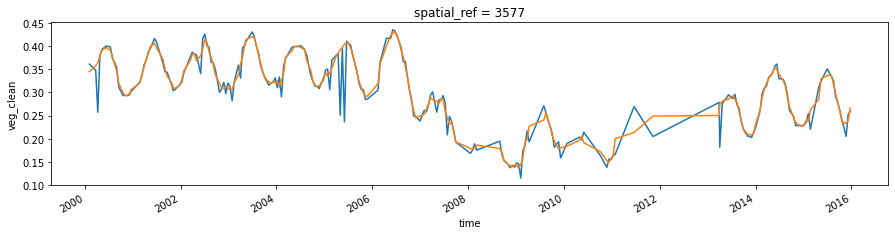

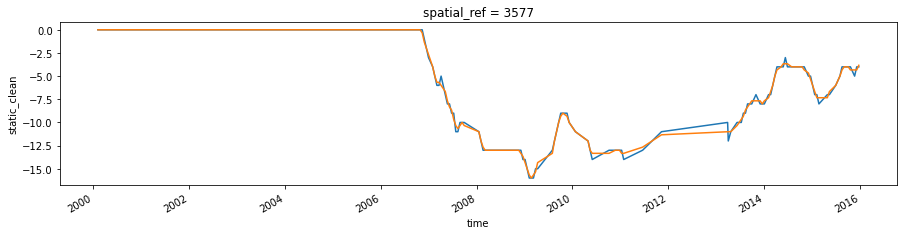

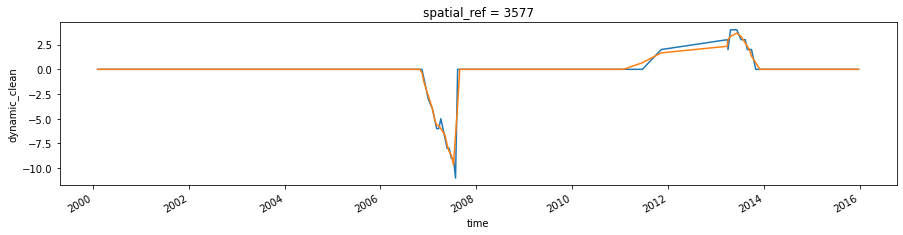

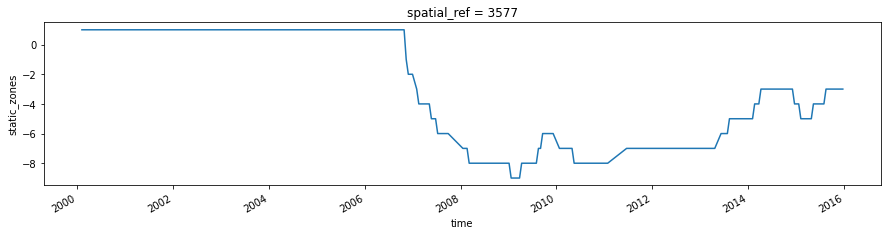

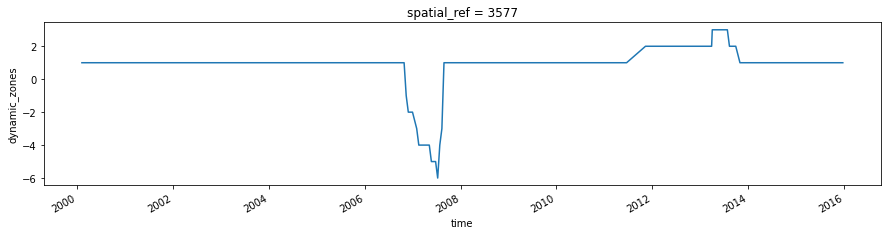

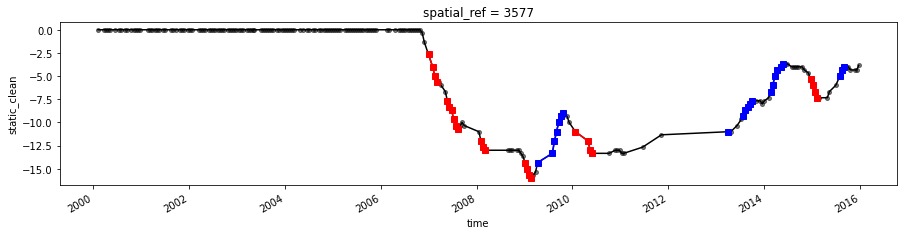

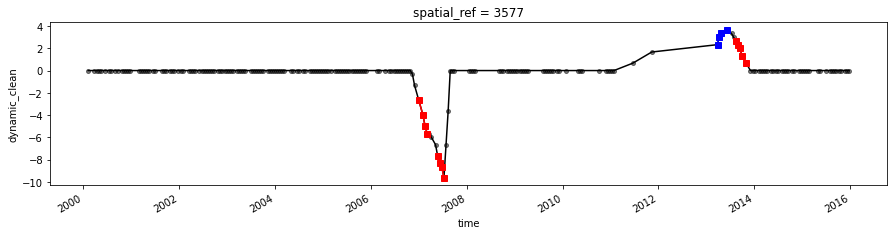

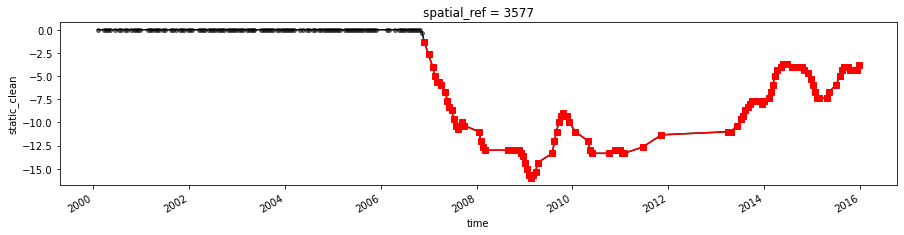

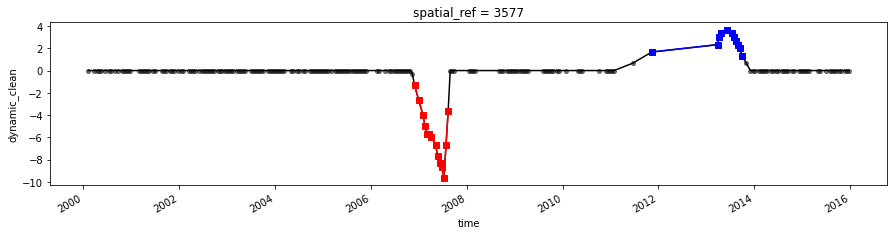

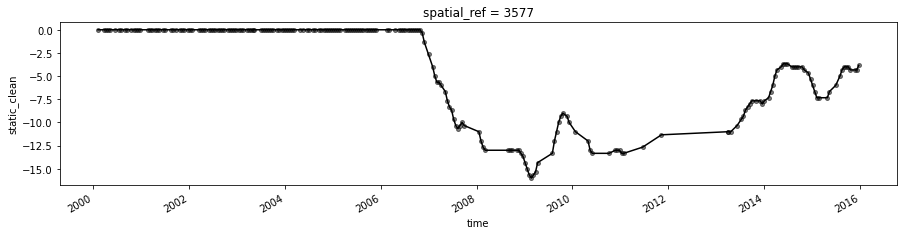

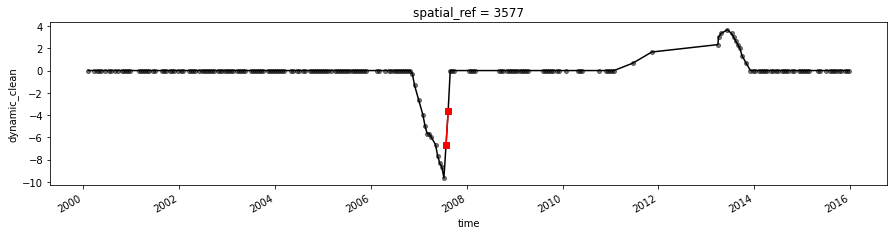

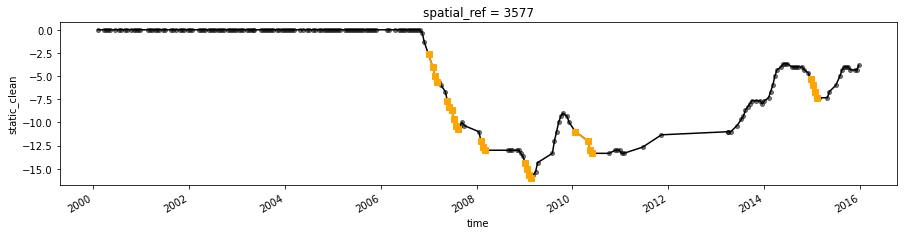

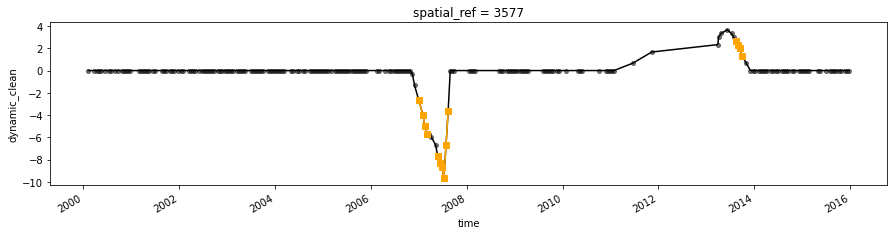

In [103]:
%matplotlib inline
import matplotlib.pyplot as plt

if True:
    fig = plt.figure(figsize=[15, 3])
    ds_tmp['veg_idx'].plot()
    ds_tmp['veg_clean'].plot()
    plt.show()

    fig = plt.figure(figsize=[15, 3])
    ds_tmp['static_raw'].plot()
    ds_tmp['static_clean'].plot()
    plt.show()

    fig = plt.figure(figsize=[15, 3])
    ds_tmp['dynamic_raw'].plot()
    ds_tmp['dynamic_clean'].plot()
    plt.show()

    fig = plt.figure(figsize=[15, 3])
    ds_tmp['static_zones'].plot()
    plt.show()

    fig = plt.figure(figsize=[15, 3])
    ds_tmp['dynamic_zones'].plot()
    plt.show()    
    
    fig = plt.figure(figsize=[15, 3])
    ds_tmp['static_clean'].plot(color='black')
    ds_tmp['static_clean'].plot(linestyle='None', markersize=4, marker='o', color='black', alpha=0.5)
    ds_tmp['static_clean'].where(ds_tmp['static_rule_one'] > 0).plot(marker='s', color='blue')
    ds_tmp['static_clean'].where(ds_tmp['static_rule_one'] < 0).plot(marker='s', color='red')
    plt.show()

    fig = plt.figure(figsize=[15, 3])
    ds_tmp['dynamic_clean'].plot(color='black')
    ds_tmp['dynamic_clean'].plot(linestyle='None', markersize=4, marker='o', color='black', alpha=0.5)
    ds_tmp['dynamic_clean'].where(ds_tmp['dynamic_rule_one'] > 0).plot(marker='s', color='blue')
    ds_tmp['dynamic_clean'].where(ds_tmp['dynamic_rule_one'] < 0).plot(marker='s', color='red')
    plt.show()
    
    fig = plt.figure(figsize=[15, 3])
    ds_tmp['static_clean'].plot(color='black')
    ds_tmp['static_clean'].plot(linestyle='None', markersize=4, marker='o', color='black', alpha=0.5)
    ds_tmp['static_clean'].where(ds_tmp['static_rule_two'] > 0).plot(marker='s', color='blue')
    ds_tmp['static_clean'].where(ds_tmp['static_rule_two'] < 0).plot(marker='s', color='red')
    plt.show()

    fig = plt.figure(figsize=[15, 3])
    ds_tmp['dynamic_clean'].plot(color='black')
    ds_tmp['dynamic_clean'].plot(linestyle='None', markersize=4, marker='o', color='black', alpha=0.5)
    ds_tmp['dynamic_clean'].where(ds_tmp['dynamic_rule_two'] > 0).plot(marker='s', color='blue')
    ds_tmp['dynamic_clean'].where(ds_tmp['dynamic_rule_two'] < 0).plot(marker='s', color='red')
    plt.show()
    
    fig = plt.figure(figsize=[15, 3])
    ds_tmp['static_clean'].plot(color='black')
    ds_tmp['static_clean'].plot(linestyle='None', markersize=4, marker='o', color='black', alpha=0.5)
    ds_tmp['static_clean'].where(ds_tmp['static_rule_three'] > 0).plot(marker='s', color='blue')
    ds_tmp['static_clean'].where(ds_tmp['static_rule_three'] < 0).plot(marker='s', color='red')
    plt.show()

    fig = plt.figure(figsize=[15, 3])
    ds_tmp['dynamic_clean'].plot(color='black')
    ds_tmp['dynamic_clean'].plot(linestyle='None', markersize=4, marker='o', color='black', alpha=0.5)
    ds_tmp['dynamic_clean'].where(ds_tmp['dynamic_rule_three'] > 0).plot(marker='s', color='blue')
    ds_tmp['dynamic_clean'].where(ds_tmp['dynamic_rule_three'] < 0).plot(marker='s', color='red')
    plt.show()
    
    fig = plt.figure(figsize=[15, 3])
    ds_tmp['static_clean'].plot(color='black')
    ds_tmp['static_clean'].plot(linestyle='None', markersize=4, marker='o', color='black', alpha=0.5)
    ds_tmp['static_clean'].where(ds_tmp['static_alerts'] > 0).plot(marker='s', color='orange')
    plt.show()
    
    fig = plt.figure(figsize=[15, 3])
    ds_tmp['dynamic_clean'].plot(color='black')
    ds_tmp['dynamic_clean'].plot(linestyle='None', markersize=4, marker='o', color='black', alpha=0.5)
    ds_tmp['dynamic_clean'].where(ds_tmp['dynamic_alerts'] > 0).plot(marker='s', color='orange')
    plt.show()

In [52]:
"""
Executes the COG Explore module.
"""

# safe imports
import os, sys       # arcgis comes with these
import numpy as np   # arcgis comes with these
import tempfile      # arcgis comes with this
import arcpy         # arcgis comes with these

# risky imports (not native to arcgis)
try:
    import xarray as xr
    import dask
except Exception as e:
    arcpy.AddError('Python libraries xarray and dask not installed.')
    arcpy.AddMessage(str(e))
    #return  

# import tools
try:
    # shared folder
    sys.path.append(FOLDER_SHARED)
    import arc, tools, satfetcher

    # shared modules
    sys.path.append(FOLDER_MODULES)
    import cog
except Exception as e:
    arcpy.AddError('Could not find tenement tools python scripts (modules, shared).')
    arcpy.AddMessage(str(e))
    #return   

# disable future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)
warnings.simplefilter(action='ignore', category=dask.array.core.PerformanceWarning)       

# grab parameter values 
#in_nc = parameters[0].valueAsText            # raw input satellite netcdf
#out_folder = parameters[1].valueAsText       # output crf folder
#in_veg_idx = parameters[2].value             # vege index name
#in_fmask_flags = parameters[3].valueAsText   # fmask flag values
#in_max_cloud = parameters[4].value           # max cloud percentage
#in_interpolate = parameters[5].value         # interpolate missing pixels



# # # # #
# notify user and set up progress bar
arcpy.AddMessage('Beginning NRT Hotspots.')
arcpy.SetProgressor(type='step', 
                    message='Preparing parameters...',
                    min_range=0, max_range=11)



# # # # # #
# # notify and increment progress bar
arcpy.SetProgressorLabel('Obtaining requested monitoring area...')
arcpy.SetProgressorPosition(1)

# select current monitoring area via id
#area = MonitoringArea()



# # # # # #
# # notify and increment progress bar
arcpy.SetProgressorLabel('Validating monitoring area...')
arcpy.SetProgressorPosition(2)

# validate current monitoring area
area.validate_area()



# # # # # #
# # notify and increment progress bar
arcpy.SetProgressorLabel('Fetching satellite data...')
arcpy.SetProgressorPosition(3)

#  TEMP END DATE
area.TESTING_END_DT = '2015-12-31'

# fetch all available satellite data
area.set_new_xr()



# # # # # #
# # notify and increment progress bar
arcpy.SetProgressorLabel('Removing invalid satellite data...')
arcpy.SetProgressorPosition(3)

# remove invalid images
area.apply_new_xr_fmask()


# # # # # #
# # notify and increment progress bar
arcpy.SetProgressorLabel('Calculating vegetation index...')
arcpy.SetProgressorPosition(3)

# generate vegetation index
area.apply_new_xr_index()


# get attributes
# todo



# subset to training period
# create new func for this in inhereted class

area.ds_new = area.ds_new.where(area.ds_new['time.year'] >= area.s_year, drop=True)


# # # # # #
# # notify and increment progress bar
arcpy.SetProgressorLabel('Compute data...')
arcpy.SetProgressorPosition(3)

# computing data
area.load_new_xr()



# # # # # #
# # notify and increment progress bar
arcpy.SetProgressorLabel('Generating and applying edge mask...')
arcpy.SetProgressorPosition(3)

# remve edge pixels
area.remove_new_xr_edges()



# # # # # #
# # notify and increment progress bar
arcpy.SetProgressorLabel('Interpolating missing values...')
arcpy.SetProgressorPosition(3)

# interpolate missing values
area.interp_new_xr_nans()



# # # # # #
# # notify and increment progress bar
arcpy.SetProgressorLabel('Adding new variables to dataset...')
arcpy.SetProgressorPosition(3)

# interpolate missing values
area.append_new_xr_vars()



# may need to remove spikes and smooth, if use

# set cmb and anl... this works!
area.set_cmb_xr()
area.set_anl_xr()

# detect change... this works!
area.detect_change_anl_xr()


#area.build_zones()
#area.build_rule_one()
#area.build_rule_two()
#area.build_rule_three()

Obtaining all satellite data for monitoring area.
Beginning STAC search for items. This can take awhile.
Searching collection: ga_ls5t_ard_3
Searching collection: ga_ls7e_ard_3
Excluding SLC-off times.
Searching collection: ga_ls8c_ard_3
Searching collection: ga_ls8c_ard_provisional_3
A total of 985 scenes were found.
Replacing url prefix: s3://dea-public-data with https://data.dea.ga.gov.au
Converting raw STAC data into xarray dataset via odc-stac.
Created xarray dataset via odc-stac successfully.
Removing dates where too many invalid pixels.
Mask band is currently dask. Computing, please wait.
Filling invalid pixels with requested nodata value.
Dropping mask band.
Removed invalid images successfully.
Conforming DEA ARD satellite band names.
Satellite band names conformed successfully.
Calculating indices: mavi.
Calculating index: mavi
Renamed default indices.
Calculated indices successfully.
Beginning change detection.
Could not train model adequately, please add more years.
Cannot c

In [74]:
%matplotlib inline

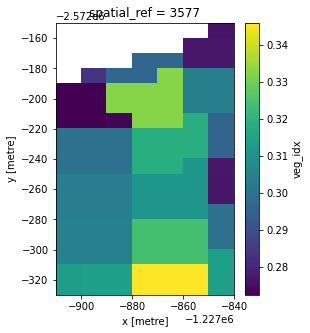

In [292]:
fig = plt.figure(figsize=[4, 5])

ds = area.ds_anl.copy(deep=True)
ds = ds[['veg_idx']]
ds = ds.median('time')

ds['veg_idx'].plot()
plt.show()

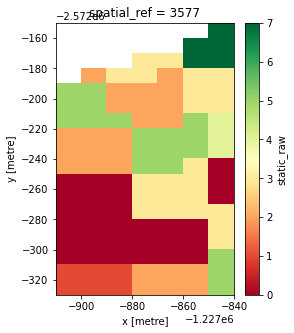

In [301]:
fig = plt.figure(figsize=[4, 5])

ds = area.ds_anl.copy(deep=True)
ds = ds[['static_raw']]

# get highest change across time
ds = ds.max('time')

ds['static_raw'].plot(cmap='RdYlGn', robust=True)
plt.show()

In [311]:
# convert coords to dataframe records 
df = ds.to_dataframe()
df = df.reset_index()

df = df[['x', 'y', 'static_raw']]
arr = df.to_numpy()

#pnts = [arcpy.Point(c[0], c[1]) for c in arr]


#df = df.to_records()

# create feat
feat = arcpy.management.CreateFeatureclass(out_path='memory', 
                                           out_name='kdense', 
                                           geometry_type='POINT', 
                                           spatial_reference=3577)

# add samples field
arcpy.AddField_management(in_table=feat, 
                          field_name='sample', 
                          field_type='LONG')

# 
with arcpy.da.InsertCursor(feat, ['SHAPE@', 'sample']) as cursor:   
    for r in arr:
        row = [arcpy.Point(r[0], r[1]), r[2]]
        cursor.insertRow(row)
        
try:
    if arcpy.CheckExtension('Spatial') == 'Available':
        arcpy.CheckOutExtension('Spatial')
        
        arcpy.env.addOutputsToMap = True
        kdense = arcpy.sa.KernelDensity(in_features=feat, 
                               population_field='sample', 
                               search_radius=30,
                               area_unit_scale_factor='SQUARE_METERS')

        arcpy.CheckInExtension('Spatial')
        
    else:
        arcpy.AddError('Spatial Analyst extension could not be checked out.')
        raise #return

except:
    arcpy.AddError('Could not generate kernel density.')
    raise # return
    

In [354]:
# apply rolling window of user size
dss = ds.rolling(x=2, 
                 y=2, 
                 center=True,
                 min_periods=1).mean()

fig = plt.figure(figsize=[4, 5])
dss['static_raw'].plot.contourf(cmap='Reds', levels=8)
plt.show()

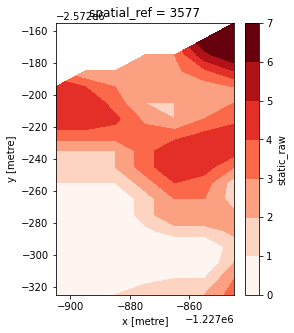

In [318]:
np.arange(ds['x'].values.min(), ds['x'].values.min(), 200)

array([], dtype=float64)

In [316]:
ds['x'].values.min(), 

-1227905.0

In [342]:
new_x = np.linspace(ds['x'].min(), ds['x'].max(), ds.dims['x'] * 5)
new_y = np.linspace(ds['y'].min(), ds['y'].max(), ds.dims['y'] * 5)

da = ds.interp(x=new_x, y=new_y)

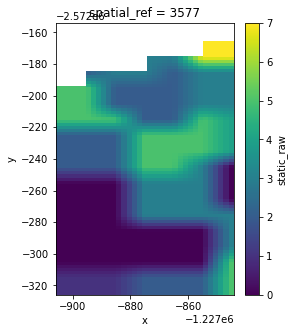

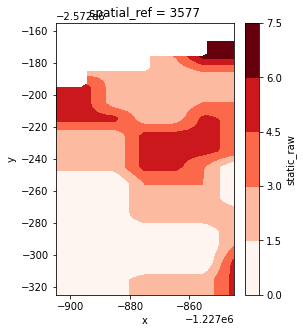

In [344]:
fig = plt.figure(figsize=[4, 5])
da['static_raw'].plot()
plt.show()

fig = plt.figure(figsize=[4, 5])
da['static_raw'].plot.contourf(cmap='Reds')
plt.show()

In [ ]:
#ds =  (ds['nbart_nir'] - ds['nbart_red']) / (ds['nbart_nir'] + ds['nbart_red'])
#ds = ds.to_dataset(name='veg_idx')

#ds = xr.where(ds['veg_idx'] > 0.6, 1, 0)

#ds = ds.sum('time')

#df = ds.to_dataframe().to_records()

arcpy.env.addOutputsToMap = False

out_fc = 'temp'
srs = arcpy.SpatialReference(3577)
tmp_feat = arcpy.management.CreateFeatureclass(out_path='in_memory', 
                                               out_name=out_fc, 
                                               geometry_type='POINT', 
                                               spatial_reference=3577)

arcpy.AddField_management(in_table=tmp_feat, 
                          field_name='samples', 
                          field_type='LONG')

fields = ['samples', 'SHAPE@XY']
with arcpy.da.InsertCursor(tmp_feat, fields) as cursor:
    for point in df:
        row = [point[3], (point[1], point[0])]
        cursor.insertRow(row)
        

try:
    if arcpy.CheckExtension('Spatial') == 'Available':
        arcpy.CheckOutExtension('Spatial')
        
        arcpy.env.addOutputsToMap = True
        kdense = KernelDensity(in_features=tmp_feat, 
                               population_field='samples', 
                               search_radius=30,
                               area_unit_scale_factor='SQUARE_METERS')

        arcpy.CheckInExtension('Spatial')
        
    else:
        arcpy.AddError('Spatial Analyst extension could not be checked out.')
        raise #return

except:
    arcpy.AddError('Could not generate kernel density.')
    raise # return
    

In [ ]:
ds = ds.sum('time')

df = ds.to_dataframe().to_records()

arcpy.env.addOutputsToMap = False

out_fc = 'temp'
srs = arcpy.SpatialReference(3577)
tmp_feat = arcpy.management.CreateFeatureclass(out_path='in_memory', 
                                               out_name=out_fc, 
                                               geometry_type='POINT', 
                                               spatial_reference=srs)

arcpy.AddField_management(in_table=tmp_feat, 
                          field_name='samples', 
                          field_type='LONG')

fields = ['samples', 'SHAPE@XY']
with arcpy.da.InsertCursor(tmp_feat, fields) as cursor:
    for point in df:
        row = [point[3], (point[1], point[0])]
        cursor.insertRow(row)
        

try:
    if arcpy.CheckExtension('Spatial') == 'Available':
        arcpy.CheckOutExtension('Spatial')
        
        arcpy.env.addOutputsToMap = True
        kdense = KernelDensity(in_features=tmp_feat, 
                               population_field='samples', 
                               search_radius=30,
                               area_unit_scale_factor='SQUARE_METERS')

        arcpy.CheckInExtension('Spatial')
        
    else:
        arcpy.AddError('Spatial Analyst extension could not be checked out.')
        raise #return

except:
    arcpy.AddError('Could not generate kernel density.')
    raise # return
    

In [442]:
class MonitoringAreaStatistics:
    """
    """

    # TESTING_END_DT REMOVE THIS WHEN DONE!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    def __init__(self, feat, path):
        
        # feature fields
        self.area_id = feat[0]
        self.platform = feat[1]
        self.s_year = feat[2]
        self.e_year = feat[3]
        self.index = feat[4]
        self.persistence = feat[5]
        self.rule_1_min_conseqs = feat[6]
        self.rule_1_inc_plateaus = feat[7]
        self.rule_2_min_zone = feat[8]
        self.rule_3_num_zones = feat[9]
        self.ruleset = feat[10]
        self.alert = feat[11]
        self.method = feat[12]
        self.alert_direction = feat[13]
        self.email = feat[14]
        self.ignore = feat[15]
        self.color = feat[16]
        self.global_id = feat[17]
        
        # feature geometry
        self.raw_geom = feat[18]
        self.prj_geom = None
        
        # path to project folder
        self.path = path
        
        # xr datasets
        self.ds = None
        
        # xr edge mask
        self.mask = None
        
        # TESTING REMOVE THIS WHEN DONE!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        self.TESTING_END_DT = None
        
        
    def show_area_info(self):
        """
        Simple function to print field information to 
        screen.
        """
        
        # print field attributes
        for field in list(vars(self))[:16]:
            print('{}: {}'.format(field, vars(self).get(field)))
            
        return
    
    
    def validate_area(self):
        """
        Checks all required monitoring area parameters are 
        valid. Raises an error if invalid.
        """

        # check area id
        if self.area_id is None:
            raise ValueError('No area id exists.')

        # check platform
        if self.platform not in ['Landsat', 'Sentinel']:
            raise ValueError('Platform not Landsat or Sentinel.')

        # check start, end years
        if not isinstance(self.s_year, int):
            raise ValueError('Start year not an integer.')
        elif not isinstance(self.e_year, int):
            raise ValueError('End year not an integer.')
        elif self.s_year < 1980 or self.s_year > 2050:
            raise ValueError('Start year not between 1980-2050.')        
        elif self.e_year < 1980 or self.e_year > 2050:
            raise ValueError('End year not between 1980-2050.')          
        elif self.e_year <= self.s_year:
            raise ValueError('End year is <= start year.')           
        elif abs(self.e_year - self.s_year) < 2:
            raise ValueError('Training period < 2 years in length.')  
        elif self.platform == 'Sentinel' and self.s_year < 2016:
            raise ValueError('Start year must be >= 2016 for Sentinel data.')  

        # check index
        if self.index not in ['NDVI', 'MAVI', 'kNDVI']:
            raise ValueError('Index must be NDVI, MAVI or kNDVI.')

        # check persistence
        if self.persistence is None:
            raise ValueError('No persistence exists.')
        elif self.persistence < 0.001 or self.persistence > 9.999:
            raise ValueError('Persistence not between 0.0001 and 9.999.')

        # check rule 1 min consequtives
        if self.rule_1_min_conseqs is None:
            raise ValueError('No rule 1 min conseqs exists.')
        elif self.rule_1_min_conseqs < 0 or self.rule_1_min_conseqs > 999:
            raise ValueError('Rule 1 min conseqs not between 0 and 999.')

        # check rule 1 inc plateaus
        if self.rule_1_inc_plateaus is None:
            raise ValueError('No rule 1 inc plateaus exists.')
        elif self.rule_1_inc_plateaus not in ['Yes', 'No']:
            raise ValueError('Rule 1 inc plateaus must be Yes or No.')

        # check rule 2 min zone
        if self.rule_2_min_zone is None:
            raise ValueError('No rule 2 min zone exists.')
        elif self.rule_2_min_zone < 1 or self.rule_2_min_zone > 11:
            raise ValueError('Rule 2 min zone not between 1 and 11.') 

        # check rule 3 num zones
        if self.rule_3_num_zones is None:
            raise ValueError('No rule 3 num zones exists.')
        elif self.rule_3_num_zones < 1 or self.rule_3_num_zones > 11:
            raise ValueError('rule 3 num zones not between 1 and 11.')             

        # set up allowed rulesets
        rulesets = [
            '1 only',
            '2 only',
            '3 only',
            '1 and 2',
            '1 and 3',
            '2 and 3',
            '1 or 2',
            '1 or 3',
            '2 or 3',
            '1 and 2 and 3',
            '1 or 2 and 3',
            '1 and 2 or 3',
            '1 or 2 or 3'
        ]

        # check ruleset   
        if self.ruleset not in rulesets:
            raise ValueError('Rulset not supported.')

        # check alert
        if self.alert not in ['Yes', 'No']:
            raise ValueError('Alert must be Yes or No.')

        # check method
        if self.method not in ['Static', 'Dynamic']:
            raise ValueError('Method must be Static or Dynamic')

        # set up alert directions 
        alert_directions = [
            'Incline only (any)', 
            'Decline only (any)', 
            'Incline only (+ zones only)', 
            'Decline only (- zones only)', 
            'Incline or Decline (any)',
            'Incline or Decline (+/- zones only)'
        ]

        # check alert direction
        if self.alert_direction not in alert_directions:
            raise ValueError('Alert direction is not supported.')

        # check email address
        if self.alert == 'Yes' and self.email is None:
            raise ValueError('No email provided.')
        elif self.email is not None and '@' not in self.email:
            raise ValueError('Email address invalid.')

        # check ignore
        if self.ignore not in ['Yes', 'No']:
            raise ValueError('Ignore must be Yes or No.')

        # check global id
        if self.global_id is None:
            raise ValueError('No global id exists.')

        # check path provided
        if self.path is None:
            raise ValueError('No project path exists.')

        return
        
        
    # TODO SET END DATE TO 2050 WHEN DONE
    def set_xr(self):
        """
        Fetches all available digital earth australia (dea) 
        landsat/sentinel data for area bounding box. Start date
        is based on provided start year. The resulting data is 
        set to the xr. If an error occurs, an error is raised. 
        """
        
        # set endpoint
        STAC_ENDPOINT = 'https://explorer.sandbox.dea.ga.gov.au/stac'
        
        # check platform is valid
        if self.platform not in ['Landsat', 'Sentinel']:
            raise ValueError('Platform not supported.')

        # prepare dea stac search parameters
        if self.platform == 'Landsat':
            
            # set dea collection names
            collections = [
                'ga_ls5t_ard_3',
                'ga_ls7e_ard_3',
                'ga_ls8c_ard_3',
                'ga_ls8c_ard_provisional_3'
            ]
            
            # set bands
            bands = [
                'nbart_red', 
                'nbart_green', 
                'nbart_blue', 
                'nbart_nir', 
                'nbart_swir_1', 
                'nbart_swir_2', 
                'oa_fmask'
            ]
            
        elif self.platform == 'Sentinel':
            
            # set dea collection names
            collections = [
                's2a_ard_granule',  # todo: use ver 3 when avail
                's2b_ard_granule',  # todo: use ver 3 when avail
                'ga_s2am_ard_provisional_3',
                'ga_s2bm_ard_provisional_3'
            ]
            
            # set bands
            bands = [
                'nbart_red', 
                'nbart_green', 
                'nbart_blue', 
                'nbart_nir_1', 
                'nbart_swir_2', 
                'nbart_swir_3', 
                'fmask'
            ]
        
        try:
            # ensure raw geom is in wgs84 (set prj_geom)
            srs = arcpy.SpatialReference(4326)
            self.prj_geom = self.raw_geom.projectAs(srs)
            
            # convert to bounding box in wgs84
            prj_bbox = [
                self.prj_geom.extent.XMin,
                self.prj_geom.extent.YMin,
                self.prj_geom.extent.XMax,
                self.prj_geom.extent.YMax
            ]
        
        except Exception as e:
            raise ValueError(e)
            
            
        # check if start date provided 
        if self.s_year is None:
            raise ValueError('No start year provided.')
            
        try:
            # prepare start date 
            start_dt = '{}-01-01'.format(self.s_year)
            
            # get all avail dea satellite data without compute
            self.ds = nrt.fetch_cube_data(collections=collections, 
                                          bands=bands, 
                                          start_dt=start_dt, 
                                          end_dt=self.TESTING_END_DT,     #'2050-12-31', 
                                          bbox=prj_bbox, 
                                          resolution=10, 
                                          ds_existing=None)
        
            # group duplicate times if exist
            self.ds = satfetcher.group_by_solar_day(self.ds)
            
        except Exception as e:
            raise ValueError(e)
            
        try:
            # enforce none type if no dates
            if len(self.ds['time']) == 0:
                self.ds = None
                
        except Exception as e:
            raise ValueError(e)
            
        return
        
        
    def apply_xr_fmask(self):
        """
        Takes the xr and applies the dea fmask band to remove 
        invalid pixels and dates. If an error occurs, error is 
        raised.
        """

        # check if xr exists
        if self.ds is None:
            raise ValueError('No xr provided.')

        try:
            # get mask band name (either be oa_fmask or fmask)
            mask = [v for v in self.ds if 'mask' in v][0]

            # mask invalid pixels i.e., not valid, water, snow
            self.ds = cog.remove_fmask_dates(ds=self.ds, 
                                             valid_class=[1, 4, 5],
                                             max_invalid=0,
                                             mask_band=mask, 
                                             nodata_value=np.nan,
                                             drop_fmask=True)
        except Exception as e:
            raise ValueError(e)

        return
    
    
    def apply_xr_index(self):
        """
        Takes the  xr and applies user chosen vegetation
        index. If an error occurs, error is raised. 
        """

        # check if xr exists
        if self.ds is None:
            raise ValueError('No xr provided.')

        # check if platform set
        if self.platform not in ['Landsat', 'Sentinel']:
            raise ValueError('Platform not supported.')

        # check if index set
        if self.index not in ['NDVI', 'MAVI', 'kNDVI']:
            raise ValueError('Index not supported.')

        try:
            # conform dea band names and calc vegetation index
            platform = self.platform.lower()
            self.ds = satfetcher.conform_dea_ard_band_names(ds=self.ds, 
                                                            platform=platform) 

            # calculate vegetation index
            index = self.index.lower()
            self.ds = tools.calculate_indices(ds=self.ds, 
                                              index=index, 
                                              custom_name='veg_idx', 
                                              rescale=False, 
                                              drop=True)
        except Exception as e:
            raise ValueError(e)

        return


    def load_xr(self):
        """
        Loads xr values into memory using the xarray 
        load function. This will result in downloading from 
        dea and can take awhile.
        """

        # check if xr exists
        if self.ds is None:
            raise ValueError('No new xr provided.')

        try:
            # load new xr and close connection 
            self.ds.load()
            self.ds.close()

        except Exception as e:
            raise ValueError(e)

        return


    def set_xr_edge_mask(self):
        """
        Sets an xr array useful for masking out edge pixels. Edge pixels 
        can occur within the original bounding box but outside of the 
        vector boundary of the monitoring area. This mask is created 
        as array of 1s and 0s (in boundary, out boundary) 
        and applies it to the xr via the apply_xr_edge_mask function. 
        If an error occurs, no mask is applied.
        """ 

        # check if xr exists
        if self.ds is None:
            raise ValueError('No xr provided.')

        # check if raw geometry exists
        if self.raw_geom is None:
            raise ValueError('No raw area geometry provided.')       

        try:
            # rasterize area polygon, set outside pixels to nan
            self.mask = nrt.rasterize_polygon(ds=self.ds, 
                                              geom=self.raw_geom)

        except Exception as e:
            self.mask = None
            raise ValueError(e)

        return


    def interp_xr_nans(self):
        """
        Interpolates any existing nan values in xr, linearly.
        If nan values still exist after interpolation (often on
        edge dates due to lack of extrapolation), these will be
        dropped. If error occurs or all values are nan, error is
        raised.
        """
        
        # check if xr exists
        if self.ds is None:
            raise ValueError('No xr provided.')          

        try:
            # interpolate na linearly
            self.ds = self.ds.interpolate_na('time')
            
            # check if any nan
            if self.ds.to_array().isnull().any():
                self.ds = self.ds.where(~self.ds.isnull(), drop=True)
        
        except Exception as e:
            raise ValueError(e)
            
        # check we have data remaining
        if len(self.ds['time']) == 0:
            raise ValueError('No data remaining after nodata dropped.')
            
        return


    def append_xr_vars(self):
        """
        Appends required xr variables to xr if do not exist.
        These variables are required for storing outputs from 
        change detection results, cleaned vegetation, etc. If
        error, error is raised.
        """
        
        # check if xr exists
        if self.ds is None:
            raise ValueError('No xr provided.')  
        
        # set required variable names
        new_vars = [
            'veg_clean', 
            'static_raw', 
            'static_clean',
            'static_rule_one',
            'static_rule_two',
            'static_rule_three',
            'static_zones',
            'static_alerts',
            'dynamic_raw', 
            'dynamic_clean',
            'dynamic_rule_one',
            'dynamic_rule_two',
            'dynamic_rule_three',
            'dynamic_zones',
            'dynamic_alerts'
        ]        
        
        # iter var names and append to xr
        for var in new_vars:
            if var not in self.ds:
                da = xr.full_like(self.ds['veg_idx'], np.nan)
                self.ds[var] = da
        
        return
    

    def fix_xr_spikes(self):
        """
        Detects severe vegetation index outliers using the TIMESAT 
        3.3 median spike detection method. Sets spike values to 
        nan and then interpolates them, if they exist. If error, error raised.
        """
        
        # check if xr exists
        if self.ds is None:
            raise ValueError('No xr provided.')
        
        try:
            # remove outliers via median spike method
            da = nrt.remove_spikes(da=self.ds['veg_idx'], 
                                   factor=1, 
                                   win_size=3)
            
            # interpolate nans linearly
            da = da.interpolate_na('time')
            
            # set result to clean var
            self.ds['veg_clean'] = da   
            
            # if nans still exists, drop them in xr
            if da.isnull().any():
                self.ds = self.ds.where(~da.isnull(), drop=True)
        
        except Exception as e:
            raise ValueError(e)
            
        # check we still have data remaining
        if len(self.ds['time']) == 0:
            raise ValueError('No data remaining after no data dropped.')
            
        return
    
    
    # if got time, see if can improve nan mask approach. id rather a vectorized approach
    def smooth_xr_index(self):
        """
        Mildly smoothes the xr clean vegetation index values 
        using the savitsky golay filter. If error, error raised.
        """

        # check if xr exists
        if self.ds is None:
            raise ValueError('No xr provided.')
            
        # reduce code with a array
        da = self.ds['veg_clean']
        
        # mask if needed
        mask = None
        if da.isnull().any():
            mask = da.isnull()
            da = da.where(~mask, da.mean())
        
        try:
            # get time dimension axis
            dims = list(da.dims)
            for idx, dim in enumerate(dims):
                if dim == 'time':
                    axis = idx

            # set up kwargs
            kwargs={
                'window_length': 3, 
                'polyorder': 1,
                'axis': axis
            }

            # apply savitsky filter to outlier-free index
            da = xr.apply_ufunc(savgol_filter, 
                                da,
                                dask='allowed',
                                kwargs=kwargs)
                
            # reset nan values if found
            if mask is not None:
                da = da.where(~mask, np.nan)

            # update existing values in xr
            self.ds['veg_clean'] = da
        
        except Exception as e:
            raise ValueError(e)
            
        return

    # TODO play with smoothing, persistence 
    # ALSO TRY MIN TRAINING LENGTH COULD WORK!!! set to 1 year worth of dates, 2 years worth of dates, etc
    # ALSO CHECK area_summary.ds['static_raw'] = area_summary.ds['static_raw'].transpose('time', 'y', 'x')
    def detect_change_xr(self):
        """
        Performs ewmacd change detection (static and dynamic 
        types) on xr. Uses the raw vegetation index time series 
        to detect the change. If error or all nan, error raised.
        """

        # check if anl xr exists
        if self.ds is None:
            raise ValueError('No xr provided.')

        # check start and end years valid
        if self.s_year is None or self.e_year is None:
            raise ValueError('No start and/or end year provided.')        

        # check if persistence is valid
        if self.persistence is None:
            raise ValueError('No persistence provided.')

        try:
            # perform ewmacd change detection
            self.ds = nrt.detect_change(ds=self.ds,
                                        method='both',
                                        var='veg_idx',
                                        train_start=self.s_year,
                                        train_end=self.e_year,
                                        persistence=self.persistence)
        except Exception as e:
            raise ValueError(e)

        # check if we have data
        for var in ['static_raw', 'dynamic_raw']:
            if self.ds[var].isnull().all():
                raise ValueError('Change result is empty.')            

        return

    
    # if got time, see if can improve nan mask approach. id rather a vectorized approach
    def smooth_xr_change(self):
        """
        Mildly smoothes the xr static and dynamic change 
        signal values using the savitsky golay filter. If error, 
        error raised.
        """

        # check if xr exists
        if self.ds is None:
            raise ValueError('No xr provided.')
            
        # set up static and dynamic arrays
        da_static = self.ds['static_raw']
        da_dynamic = self.ds['dynamic_raw']

        # create static mask if needed
        mask_static = None
        if da_static.isnull().any():
            mask_static = da_static.isnull()
            da_static = da_static.where(~mask_static, da_static.mean())
        
        # now create dynamic mask if needed
        mask_dynamic = None
        if da_dynamic.isnull().any():
            mask_dynamic = da_dynamic.isnull()
            da_dynamic = da_dynamic.where(~mask_dynamic, da_dynamic.mean())

        try:
            # get time dimension axis
            dims = list(self.ds.dims)
            for idx, dim in enumerate(dims):
                if dim == 'time':
                    axis = idx

            # set up kwargs
            kwargs={
                'window_length': 3, 
                'polyorder': 1,
                'axis': axis
            }

            # apply savitsky filter to static change values
            da_static = xr.apply_ufunc(savgol_filter, 
                                       da_static,
                                       dask='allowed',
                                       kwargs=kwargs)

            # apply savitsky filter to dynamic change values
            da_dynamic = xr.apply_ufunc(savgol_filter, 
                                        da_dynamic,
                                        dask='allowed',
                                        kwargs=kwargs)
                
                        
            # reset static nan values if found
            if mask_static is not None:
                da_static = da_static.where(~mask_static, np.nan)
                
            # now reset dynamic nan values if found
            if mask_dynamic is not None:
                da_dynamic = da_dynamic.where(~mask_dynamic, np.nan)
            
            # update static, dynamic clean values in xr
            self.ds['static_clean'] = da_static
            self.ds['dynamic_clean'] = da_dynamic
            
        except Exception as e:
            raise ValueError(e)

        return       


    def build_zones(self):
        """
        Takes cleaned static and dynamic change deviation
        values and classifies them into 1 of 11 zones based
        on where the change value falls. Honours direction 
        of change by returning zone value with sign (+/-).
        If error occurs, error raised.
        """
        
        # check if xr exists
        if self.ds is None:
            raise ValueError('No xr provided.')
        
        # check if required vars in xr
        if 'static_clean' not in self.ds:
            raise ValueError('No clean static variable.')
        elif 'dynamic_clean' not in self.ds:
            raise ValueError('No clean dynamic variable.')
                    
        try:
            # build zone values using smoothed static signal
            da = self.ds['static_clean']
            self.ds['static_zones'] = xr.apply_ufunc(nrt.build_zones, da)

            # build zone values using smoothed dynamic signal
            da = self.ds['dynamic_clean']
            self.ds['dynamic_zones'] = xr.apply_ufunc(nrt.build_zones, da)
        
        except Exception as e:
            raise ValueError(e)
            
        # check if we have any data
        for var in ['static_zones', 'dynamic_zones']:
            if self.ds[var].isnull().all():
                raise ValueError('Zone result is empty.')
            
        return
    
    
    # doesnt work for 2d
    def build_rule_one(self):
        """
        Takes cleaned static and dynamic change deviation
        values and applies rule one rules to them. Rule one
        calculates consequtive runs of values across time.
        Honours direction of change by returning value 
        with sign (+/-). If error occurs, error raised.
        """
        
        # check if xr exists
        if self.ds is None:
            raise ValueError('No anl xr provided.')
        
        # check if required vars in xr
        if 'static_clean' not in self.ds:
            raise ValueError('No clean static variable.')
        elif 'dynamic_clean' not in self.ds:
            raise ValueError('No clean dynamic variable.')
        
        # check if rule one parameters valid
        if self.rule_1_min_conseqs is None:
            raise ValueError('No minimum consequtives provided.')
        elif self.rule_1_inc_plateaus is None:
            raise ValueError('No include plateaus provided.')   
            
        # prepare plateaus
        if self.rule_1_inc_plateaus == 'Yes':
            plateaus = True
        else:
            plateaus = False
            
        # set kwarg options
        kwargs = {
            'min_conseqs': self.rule_1_min_conseqs,
            'inc_plateaus': plateaus
        }

        try:
            # generate all rule 1 runs (+/-) for static change
            da = self.ds['static_clean']
            self.ds['static_rule_one'] = xr.apply_ufunc(nrt.build_rule_one_runs,
                                                        da,
                                                        kwargs=kwargs)

            # generate all rule 1 runs (+/-) for dynamic change
            da = self.ds['dynamic_clean']
            self.ds['dynamic_rule_one'] = xr.apply_ufunc(nrt.build_rule_one_runs,
                                                         da,
                                                         kwargs=kwargs)
        except Exception as e:
            raise ValueError(e)

        # check if we have any data
        for var in ['static_rule_one', 'dynamic_rule_one']:
            if self.ds[var].isnull().all():
                raise ValueError('Rule one result empty.')
            
        return
    
    
    def apply_xr_edge_mask(self):
        """
        Applies the xr edge mask generated earlier during the 
        set_xr_edge_mask function. Any pixels within this mask 
        will be set to nodata (nan). If an error occurs, no mask 
        is applied.
        """ 

        # check if xr exists
        if self.ds is None:
            raise ValueError('No xr provided.')

        # check if edge mask exists
        if self.mask is None:
            raise ValueError('No edge mask provided.')       

        try:
            # take a copy in case of error
            tmp = self.ds.copy(deep=True)

            # mask edge pixels to nan
            self.ds = self.ds.where(self.mask)

            # check if not all nan
            if self.ds.to_array().isnull().all():
                raise ValueError('Mask set all pixels to nan, rolling back.')  

        except Exception as e:
            self.ds = tmp
            raise ValueError(e)

        return

In [445]:
area_summary = MonitoringAreaStatistics(feat, path=in_path)
area_summary.TESTING_END_DT = '2015-12-31'

try:
    # validate area
    area_summary.validate_area()
except Exception as e:
    raise ValueError(e)


try:
    # get and set all sat data from start training to now
    area_summary.set_xr()
except Exception as e:
    raise ValueError(e)


try:
    # apply fmask
    area_summary.apply_xr_fmask()
except Exception as e:
    raise ValueError(e)

    
try:
    # calculate veg index
    area_summary.apply_xr_index()
except Exception as e:
    raise ValueError(e)
    
    
try:
    # load (download) dataset
    area_summary.load_xr()
except Exception as e:
    raise ValueError(e)   
    
    
try:
    # set pixel edge mask here, apply later (need geobox)
    area_summary.set_xr_edge_mask()
except Exception as e:
    raise ValueError(e)

    
try:
    # interpolate nans
    area_summary.interp_xr_nans()
except Exception as e:
    raise ValueError(e)
    
    
try:
    # append required vars
    area_summary.append_xr_vars()
except Exception as e:
    raise ValueError(e) 
    
    
try:
    # fix spikes (may not want)
    area_summary.fix_xr_spikes()
except Exception as e:
    raise ValueError(e) 
    

try:
    # smooth vege via savitsky golay
    area_summary.smooth_xr_index()
except Exception as e:
    raise ValueError(e)  


try:
    # fix spikes (may not want)
    area_summary.detect_change_xr()
except Exception as e:
    raise ValueError(e) 


try:
    # smooth change via savitsky golay
    area_summary.smooth_xr_change()
except Exception as e:
    raise ValueError(e)
    
    
#try:
    # generate zones
    #area_summary.build_zones()
#except Exception as e:
    #raise ValueError(e)
    
    
# doesnt work 
#try:
    # generate build rule one
    #area_summary.build_rule_one()
#except Exception as e:
    #raise ValueError(e)

    
    
    
try:
    #generate zones
    area_summary.apply_xr_edge_mask()
except Exception as e:
    raise ValueError(e)   



Obtaining all satellite data for monitoring area.
Beginning STAC search for items. This can take awhile.
Searching collection: ga_ls5t_ard_3
Searching collection: ga_ls7e_ard_3
Excluding SLC-off times.
Searching collection: ga_ls8c_ard_3
Searching collection: ga_ls8c_ard_provisional_3
A total of 519 scenes were found.
Replacing url prefix: s3://dea-public-data with https://data.dea.ga.gov.au
Converting raw STAC data into xarray dataset via odc-stac.
Created xarray dataset via odc-stac successfully.
Removing dates where too many invalid pixels.
Mask band is currently dask. Computing, please wait.
Filling invalid pixels with requested nodata value.
Dropping mask band.
Removed invalid images successfully.
Conforming DEA ARD satellite band names.
Satellite band names conformed successfully.
Calculating indices: mavi.
Calculating index: mavi
Renamed default indices.
Calculated indices successfully.
Removing spike outliers.
Spike removal completed successfully.
Beginning change detection.


In [657]:
#ds_min = ds.min('time')
#ds_max = ds.max('time')
#ds_med = ds.median('time')
#ds_sum = ds.sum('time')
#ds_std = ds.std('time')

# alerts 
#da_alerts = ds_sum['static_alerts']
da_alerts = ds_sum['static_clean']

# apply density kernel


# apply rolling window of user size
#_ = da_alerts.rolling(x=3, y=3, center=True, min_periods=1).mean()

fig = plt.figure(figsize=[4, 5])
p = _.plot.contourf(levels=24)
#plt.show()

fig.canvas.draw()
temp_canvas = fig.canvas
plt.close()

In [688]:
import scipy.stats as stats

xy = da_alerts.to_dataframe()
xy = xy.reset_index()

#x = xy['x'].values
#y = xy['y'].values

df = xy.drop(columns='spatial_ref')

In [676]:
#data = xy.plot.kde().get_lines()[0].get_xydata()

In [690]:
density = stats.gaussian_kde(df)

LinAlgError: 4-th leading minor of the array is not positive definite

In [421]:
# potential approach to build rule one
ds = area_summary.ds.copy(deep=True)
ds = ds.isel(x=-1, y=-2)

template = xr.full_like(ds['static_clean'], np.nan)
x = ds['static_raw'].map_blocks(nrt.build_rule_one_runs,
                                template=template,
                                kwargs=kwargs)

x

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0., -3.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0

In [433]:
ds.where(area_summary.mask)

<xarray.Dataset>
Dimensions:             (time: 222, x: 7, y: 18)
Coordinates:
  * x                   (x) float64 -1.228e+06 -1.228e+06 ... -1.228e+06
  * y                   (y) float64 -2.572e+06 -2.572e+06 ... -2.572e+06
    spatial_ref         int32 3577
  * time                (time) datetime64[ns] 2000-02-06T01:49:38 ... 2015-12...
Data variables: (12/16)
    veg_idx             (time, y, x) float32 nan nan nan nan ... nan nan nan nan
    veg_clean           (time, y, x) float32 nan nan nan nan ... nan nan nan nan
    static_raw          (y, x, time) float32 nan nan nan nan ... nan nan nan nan
    static_clean        (y, x, time) float32 nan nan nan nan ... 1.0 1.0 1.0 1.0
    static_rule_one     (time, y, x) float32 nan nan nan nan ... nan nan nan nan
    static_rule_two     (time, y, x) float32 nan nan nan nan ... nan nan nan nan
    ...                  ...
    dynamic_clean       (y, x, time) float32 nan nan nan nan ... 0.0 0.0 0.0 0.0
    dynamic_rule_one    (time, y, x) float32 nan nan nan nan ... nan nan nan nan
    dynamic_rule_two    (time, y, x) float32 nan nan nan nan ... nan nan nan nan
    dynamic_rule_three  (time, y, x) float32 nan nan nan nan ... nan nan nan nan
    dynamic_zones       (time, y, x) float32 nan nan nan nan ... nan nan nan nan
    dynamic_alerts      (time, y, x) float32 nan nan nan nan ... nan nan nan nan
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

In [432]:
area_summary.mask

<xarray.DataArray (y: 19, x: 11)>
array([[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0],
       [0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0],
       [0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0],
       [0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0],
       [0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0],
       [0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0],
       [0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0],
       [0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0],
       [0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0],
       [0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0],
       [0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0],
       [0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0],
       [0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0],
       [0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0],
       [0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0],
       [0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0],
       [0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=uint8)
Coordinates:
  * y        (y) float64 -2.572e+06 -2.572e+06 ... -2.572e+06 -2.572e+06
  * x        (x) float64 -1.228e+06 -1.228e+06 ... -1.228e+06 -1.228e+06